In [1]:
!pip install deap

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
!pip install bitstring

     |████████████████████████████████| 195 kB 2.8 MB/s 
  Created wheel for bitstring: filename=bitstring-3.1.7-py3-none-any.whl size=37946 sha256=9834731a310cfc1a22ff288a7a7f8b143ad07124161844e137c4d548e808d2c5
  Stored in directory: /root/.cache/pip/wheels/de/df/5d/fb4c06c6f1469ae5a826a471cab0cbb5661f6fff9be1cd493e
Successfully built bitstring
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [3]:
!pip install transforms3d

     |████████████████████████████████| 62 kB 728 kB/s 
  Created wheel for transforms3d: filename=transforms3d-0.3.1-py3-none-any.whl size=59372 sha256=4dbb9e1af2abd6e1fa656e0de4ce89c922e1290723d62240c16da7a66e54f35d
  Stored in directory: /root/.cache/pip/wheels/b5/b7/93/8985551f83720ce37548a5b543c75380bb707955a9c2c5d28c
Successfully built transforms3d
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [4]:
!pip install tsaug

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [5]:
import os
import pandas as pd
import numpy as np
from sklearn.utils import shuffle
from scipy import stats 
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D
from tensorflow.keras.models import Model, Sequential
from tensorflow.compat.v1.keras.layers import CuDNNLSTM
from tensorflow.keras.layers import RepeatVector
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras import layers
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import mean_squared_error
from tensorflow.keras.utils import plot_model
from sklearn.impute import KNNImputer
from sklearn.metrics import r2_score
from sklearn.metrics import max_error
from deap import base, creator, tools, algorithms
from scipy.stats import bernoulli
from bitstring import BitArray
from scipy.interpolate import CubicSpline      # for warping
from transforms3d.axangles import axangle2mat  # for rotation
from tsaug import TimeWarp, Crop, Quantize, Drift, Reverse

from math import sqrt
from matplotlib import pyplot
from sklearn.preprocessing import LabelEncoder

In [6]:
pwd

'/kaggle/working'

In [7]:
#%%time 
#!wget -O owid-covid-data.csv https://covid.ourworldindata.org/data/owid-covid-data.csv

In [8]:
df = pd.read_csv('../input/covid-maroc-until-august-15/owid-covid-data.csv')

In [9]:
# Informations dur les données
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36984 entries, 0 to 36983
Data columns (total 36 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   iso_code                         36920 non-null  object 
 1   continent                        36691 non-null  object 
 2   location                         36984 non-null  object 
 3   date                             36984 non-null  object 
 4   total_cases                      36632 non-null  float64
 5   new_cases                        36632 non-null  float64
 6   total_deaths                     36632 non-null  float64
 7   new_deaths                       36632 non-null  float64
 8   total_cases_per_million          36568 non-null  float64
 9   new_cases_per_million            36568 non-null  float64
 10  total_deaths_per_million         36568 non-null  float64
 11  new_deaths_per_million           36568 non-null  float64
 12  new_tests         

In [10]:
# Les 5 premères lignes du dataset 
df.head(5)

,iso_code,continent,location,date,total_cases,new_cases,total_deaths,new_deaths,total_cases_per_million,new_cases_per_million,...,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy
0,AFG,Asia,Afghanistan,2019-12-31,0.0,0.0,0.0,0.0,0.0,0.0,...,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83
1,AFG,Asia,Afghanistan,2020-01-01,0.0,0.0,0.0,0.0,0.0,0.0,...,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83
2,AFG,Asia,Afghanistan,2020-01-02,0.0,0.0,0.0,0.0,0.0,0.0,...,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83
3,AFG,Asia,Afghanistan,2020-01-03,0.0,0.0,0.0,0.0,0.0,0.0,...,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83
4,AFG,Asia,Afghanistan,2020-01-04,0.0,0.0,0.0,0.0,0.0,0.0,...,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83


In [11]:
df[df.continent  == 'Africa'].shape
# soit 54 pays en afrique ,3 mois de COVID = approximativement 4800

(8414, 36)

In [12]:
#Taille des données de COVID pour le Maroc
df[df.location  == 'Morocco'].shape

(191, 36)

In [13]:
#Première date d'enregistrement de cas dans le monde 
df.date.min()

'2019-12-31'

In [14]:
# dernière date d'enregistrement pour notre datset
df.date.max()

'2020-08-15'

In [15]:
# Première date d'enregistrement de cas au Maroc 
df[(df.location  == 'Morocco')].date.min()

'2020-02-07'

In [16]:
# dernière date d'enregistrement de cas au Maroc 
df[(df.location  == 'Morocco')].date.max()

'2020-08-15'

In [17]:
df.date= pd.to_datetime(df['date'],format='%Y-%m-%d')

In [18]:
df=df[['new_cases','total_cases','total_deaths','new_deaths', 'population','date','location']]


In [19]:
df = df.fillna(df.median())

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  """Entry point for launching an IPython kernel.


In [20]:
df[(df.location  == 'Morocco')].tail(10)

,new_cases,total_cases,total_deaths,new_deaths,population,date,location
23085,1283.0,28500.0,435.0,18.0,36910558.0,2020-08-06,Morocco
23086,1144.0,29644.0,449.0,14.0,36910558.0,2020-08-07,Morocco
23087,1018.0,30662.0,461.0,12.0,36910558.0,2020-08-08,Morocco
23088,1345.0,32007.0,480.0,19.0,36910558.0,2020-08-09,Morocco
23089,1230.0,33237.0,498.0,18.0,36910558.0,2020-08-10,Morocco
23090,826.0,34063.0,516.0,18.0,36910558.0,2020-08-11,Morocco
23091,1132.0,35195.0,533.0,17.0,36910558.0,2020-08-12,Morocco
23092,1499.0,36694.0,556.0,23.0,36910558.0,2020-08-13,Morocco
23093,1241.0,37935.0,584.0,28.0,36910558.0,2020-08-14,Morocco
23094,1306.0,39241.0,611.0,27.0,36910558.0,2020-08-15,Morocco


In [21]:
def DA_Jitter(X, sigma=0.05):
    myNoise = np.random.normal(loc=0, scale=sigma, size=X.shape)
    myNoise =  np.add(myNoise,abs(np.min(myNoise)))
    return X+myNoise

In [22]:
def DA_Scaling(X, sigma=0.1):
    scalingFactor = np.random.normal(loc=1.0, scale=sigma, size=(1,X.shape[1])) # shape=(1,3)
    scalingFactor = np.add(scalingFactor,abs(np.min(scalingFactor)))
    myNoise = np.matmul(np.ones((X.shape[0],1)), scalingFactor)
    return X*myNoise

In [23]:
def DA_Rotation(X):
    axis = np.random.uniform(low=-1, high=1, size=X.shape[1])
    angle = np.random.uniform(low=-np.pi, high=np.pi)
    return np.matmul(X , axangle2mat(axis,angle))

In [24]:
#df['month'] = df['date'].dt.month

In [25]:
nb_seq=7
n_out=7
nb_col=5

In [26]:
start_date = '2020-03-02'
end_date = '2020-07-13'
start_date2 ='2020-07-12'
end_date2 = '2020-08-15'

In [27]:
#mask = (covid_data['date'] >= start_date) & (covid_data['date'] <= end_date) &  (covid_data['location'].isin(['Morocco']))
mask1 = (df['date'] >= start_date) & (df['date'] <= end_date) &  (df['location'].isin(['Morocco']))

In [28]:
mask2 = (df['date'] >= start_date2) & (df['date'] <= end_date2) &  (df['location'].isin(['Morocco']))

In [29]:
df.sort_values(by=['location'], inplace=True)


In [30]:
X_train = df.loc[mask1].sort_index(axis = 0) 
X_train.shape

(134, 7)

In [31]:
X_train.head(5)

,new_cases,total_cases,total_deaths,new_deaths,population,date,location
22928,7.0,615.0,10.0,0.0,36910558.0,2020-03-02,Morocco
22929,1.0,1.0,0.0,0.0,36910558.0,2020-03-03,Morocco
22930,7.0,615.0,10.0,0.0,36910558.0,2020-03-04,Morocco
22931,7.0,615.0,10.0,0.0,36910558.0,2020-03-05,Morocco
22932,1.0,2.0,0.0,0.0,36910558.0,2020-03-06,Morocco


In [32]:
X_train.tail(5)

,new_cases,total_cases,total_deaths,new_deaths,population,date,location
23057,442.0,14771.0,242.0,7.0,36910558.0,2020-07-09,Morocco
23058,178.0,14949.0,242.0,0.0,36910558.0,2020-07-10,Morocco
23059,379.0,15328.0,243.0,1.0,36910558.0,2020-07-11,Morocco
23060,214.0,15542.0,245.0,2.0,36910558.0,2020-07-12,Morocco
23061,203.0,15745.0,250.0,5.0,36910558.0,2020-07-13,Morocco


In [33]:
#Date to add test set 
data_add_test = X_train[X_train.location =='Morocco'].tail(nb_seq)

In [34]:
'''
# AUGMENTATION 

start_date = '2020-06-25'
end_date = '2020-07-31'
mask = (df['date'] >= start_date) & (df['date'] <= end_date) &  (df['location'].isin(['Morocco']))
X_1 = df.loc[mask].sort_index(axis = 0) 
X_2 = X_3 = X_4 =X_5=X_6=X_7=X_8= X_1

X_2[['new_cases']] = DA_Jitter(X_2[['new_cases']], sigma=1000)
X_2[['total_cases']] = X_2['total_cases'] + X_2['new_cases']
X_2[['new_deaths']] = DA_Jitter(X_2[['new_deaths']], sigma=10)
X_2[['total_deaths']] = X_2['total_deaths'] + X_2['new_deaths']

X_3[['new_cases']] = DA_Jitter(X_3[['new_cases']], sigma=500)
X_3[['total_cases']] = X_3['total_cases'] + X_3['new_cases']
X_3[['new_deaths']] = DA_Jitter(X_3['new_deaths'], sigma=20)
X_3[['total_deaths']] = X_3['total_deaths'] + X_3['new_deaths']

X_4[['new_cases']] = DA_Jitter(X_4[['new_cases']], sigma=1000)
X_4[['total_cases']] = X_4['total_cases'] + X_4['new_cases']
X_4[['new_deaths']] = DA_Jitter(X_4[['new_deaths']], sigma=30)
X_4[['total_deaths']] = X_4['total_deaths'] + X_4['new_deaths']

X_5[['new_cases']] = DA_Jitter(X_5[['new_cases']], sigma=1000)
X_5[['total_cases']] = X_5['total_cases'] + X_5['new_cases']
X_5[['new_deaths']] = DA_Jitter(X_5[['new_deaths']], sigma=40)
X_5[['total_deaths']] = X_5['total_deaths'] + X_5['new_deaths']

X_6[['new_cases']] = DA_Jitter(X_6[['new_cases']], sigma=1000)
X_6[['total_cases']] = X_6['total_cases'] + X_6['new_cases']
X_6[['new_deaths']] = DA_Jitter(X_6[['new_deaths']], sigma=50)
X_6[['total_deaths']] = X_6['total_deaths'] + X_6['new_deaths']


#X_7[['new_cases','total_cases','total_deaths', 'new_deaths', 'population']] = DA_Scaling(X_6[['new_cases','total_cases','total_deaths', 'new_deaths', 'population']], sigma=2000)
#X_8[['new_cases','total_cases','total_deaths', 'new_deaths', 'population']] = DA_Scaling(X_7[['new_cases','total_cases','total_deaths', 'new_deaths', 'population']], sigma=3000)
#X_4 = pd.DataFrame(X_4,columns=cols_need)
#print(X_1.shape)
X_train = pd.concat([X_train, X_2,X_3,X_4,X_5,X_6], ignore_index=True)
'''

"\n# AUGMENTATION \n\nstart_date = '2020-06-25'\nend_date = '2020-07-31'\nmask = (df['date'] >= start_date) & (df['date'] <= end_date) &  (df['location'].isin(['Morocco']))\nX_1 = df.loc[mask].sort_index(axis = 0) \nX_2 = X_3 = X_4 =X_5=X_6=X_7=X_8= X_1\n\nX_2[['new_cases']] = DA_Jitter(X_2[['new_cases']], sigma=1000)\nX_2[['total_cases']] = X_2['total_cases'] + X_2['new_cases']\nX_2[['new_deaths']] = DA_Jitter(X_2[['new_deaths']], sigma=10)\nX_2[['total_deaths']] = X_2['total_deaths'] + X_2['new_deaths']\n\nX_3[['new_cases']] = DA_Jitter(X_3[['new_cases']], sigma=500)\nX_3[['total_cases']] = X_3['total_cases'] + X_3['new_cases']\nX_3[['new_deaths']] = DA_Jitter(X_3['new_deaths'], sigma=20)\nX_3[['total_deaths']] = X_3['total_deaths'] + X_3['new_deaths']\n\nX_4[['new_cases']] = DA_Jitter(X_4[['new_cases']], sigma=1000)\nX_4[['total_cases']] = X_4['total_cases'] + X_4['new_cases']\nX_4[['new_deaths']] = DA_Jitter(X_4[['new_deaths']], sigma=30)\nX_4[['total_deaths']] = X_4['total_deaths'

In [35]:
X_train.shape

(134, 7)

In [36]:
X_train.head(10)

,new_cases,total_cases,total_deaths,new_deaths,population,date,location
22928,7.0,615.0,10.0,0.0,36910558.0,2020-03-02,Morocco
22929,1.0,1.0,0.0,0.0,36910558.0,2020-03-03,Morocco
22930,7.0,615.0,10.0,0.0,36910558.0,2020-03-04,Morocco
22931,7.0,615.0,10.0,0.0,36910558.0,2020-03-05,Morocco
22932,1.0,2.0,0.0,0.0,36910558.0,2020-03-06,Morocco
22933,7.0,615.0,10.0,0.0,36910558.0,2020-03-07,Morocco
22934,7.0,615.0,10.0,0.0,36910558.0,2020-03-08,Morocco
22935,7.0,615.0,10.0,0.0,36910558.0,2020-03-09,Morocco
22936,7.0,615.0,10.0,0.0,36910558.0,2020-03-10,Morocco
22937,7.0,615.0,10.0,0.0,36910558.0,2020-03-11,Morocco


In [37]:
X_train.tail(10)

,new_cases,total_cases,total_deaths,new_deaths,population,date,location
23052,319.0,13288.0,230.0,1.0,36910558.0,2020-07-04,Morocco
23053,534.0,13822.0,232.0,2.0,36910558.0,2020-07-05,Morocco
23054,393.0,14215.0,235.0,3.0,36910558.0,2020-07-06,Morocco
23055,114.0,14329.0,235.0,0.0,36910558.0,2020-07-07,Morocco
23056,0.0,14329.0,235.0,0.0,36910558.0,2020-07-08,Morocco
23057,442.0,14771.0,242.0,7.0,36910558.0,2020-07-09,Morocco
23058,178.0,14949.0,242.0,0.0,36910558.0,2020-07-10,Morocco
23059,379.0,15328.0,243.0,1.0,36910558.0,2020-07-11,Morocco
23060,214.0,15542.0,245.0,2.0,36910558.0,2020-07-12,Morocco
23061,203.0,15745.0,250.0,5.0,36910558.0,2020-07-13,Morocco


In [38]:
X_test = df.loc[mask2].sort_index(axis = 0) 

X_test.shape

(35, 7)

In [39]:
X_test = pd.concat([pd.DataFrame(data_add_test),X_test], ignore_index=True)
X_test = X_test.sort_index(axis = 0)

In [40]:
X_test

,new_cases,total_cases,total_deaths,new_deaths,population,date,location
0,114.0,14329.0,235.0,0.0,36910558.0,2020-07-07,Morocco
1,0.0,14329.0,235.0,0.0,36910558.0,2020-07-08,Morocco
2,442.0,14771.0,242.0,7.0,36910558.0,2020-07-09,Morocco
3,178.0,14949.0,242.0,0.0,36910558.0,2020-07-10,Morocco
4,379.0,15328.0,243.0,1.0,36910558.0,2020-07-11,Morocco
5,214.0,15542.0,245.0,2.0,36910558.0,2020-07-12,Morocco
6,203.0,15745.0,250.0,5.0,36910558.0,2020-07-13,Morocco
7,214.0,15542.0,245.0,2.0,36910558.0,2020-07-12,Morocco
8,203.0,15745.0,250.0,5.0,36910558.0,2020-07-13,Morocco
9,191.0,15936.0,255.0,5.0,36910558.0,2020-07-14,Morocco


In [41]:
X_test['timestamp'] = pd.to_datetime(X_test['date'], infer_datetime_format=True)
X_test.set_index('timestamp', inplace=True)

X_train['timestamp'] = pd.to_datetime(X_train['date'], infer_datetime_format=True)
X_train.set_index('timestamp', inplace=True)

In [42]:
X_train=X_train[['new_cases','total_cases','total_deaths', 'new_deaths', 'population']]

X_test=X_test[['new_cases','total_cases','total_deaths', 'new_deaths', 'population']]
Y_test=X_test[['new_cases']]

Y_train=X_train[['new_cases']]

In [43]:
days=X_test[nb_seq:].index
days=days.sort_values()

In [44]:
#days=days[nb_seq:]

In [45]:
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(134, 5)
(134, 1)
(42, 5)
(42, 1)


In [46]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
scaler2= MinMaxScaler(feature_range=(0, 1))

In [47]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [48]:

X_train=X_train
X_test=X_test
Y_train=Y_train
Y_test=Y_test

# ensure all data is float
X_train = X_train.astype('float32')
# ensure all data is float
X_test = X_test.astype('float32')
# ensure all data is float
Y_test = Y_test.astype('float32')
# ensure all data is float
Y_train = Y_train.astype('float32')

# normalize features

X_train= scaler.fit_transform(X_train)
X_test= scaler.fit_transform(X_test)
Y_train= scaler2.fit_transform(Y_train)
Y_test= scaler2.fit_transform(Y_test)

# reframe as supervised learning
# on doit toujours vers une conversion vers n_out ensuite con choisit le nombre de colonnes dont nous avons besoins
X_train = series_to_supervised(X_train, nb_seq, n_out)
X_test = series_to_supervised(X_test, nb_seq, n_out)
print(X_train)
print(X_train.shape)
print(X_test.shape)
Y_train = series_to_supervised(Y_train, nb_seq, n_out)
Y_test = series_to_supervised(Y_test, nb_seq, n_out)
print(Y_train.shape)
print(Y_test.shape)


     var1(t-7)  var2(t-7)  var3(t-7)  var4(t-7)  var5(t-7)  var1(t-6)  \
7     0.010886   0.038999      0.040   0.000000        0.0   0.001555   
8     0.001555   0.000000      0.000   0.000000        0.0   0.010886   
9     0.010886   0.038999      0.040   0.000000        0.0   0.010886   
10    0.010886   0.038999      0.040   0.000000        0.0   0.001555   
11    0.001555   0.000064      0.000   0.000000        0.0   0.010886   
..         ...        ...        ...        ...        ...        ...   
123   0.670295   0.720084      0.868   0.066667        0.0   0.458787   
124   0.458787   0.738821      0.872   0.066667        0.0   0.379471   
125   0.379471   0.754319      0.880   0.133333        0.0   0.272162   
126   0.272162   0.765434      0.884   0.066667        0.0   0.370140   
127   0.370140   0.780551      0.900   0.266667        0.0   0.377916   

     var2(t-6)  var3(t-6)  var4(t-6)  var5(t-6)  ...  var1(t+5)  var2(t+5)  \
7     0.000000      0.000   0.000000        0

In [49]:
print(X_test)

    var1(t-7)  var2(t-7)  var3(t-7)  var4(t-7)  var5(t-7)  var1(t-6)  \
7    0.076051   0.000000   0.000000   0.000000        0.0   0.000000   
8    0.000000   0.000000   0.000000   0.000000        0.0   0.294863   
9    0.294863   0.017742   0.018617   0.250000        0.0   0.118746   
10   0.118746   0.024888   0.018617   0.000000        0.0   0.252835   
11   0.252835   0.040101   0.021277   0.035714        0.0   0.142762   
12   0.142762   0.048691   0.026596   0.071429        0.0   0.135424   
13   0.135424   0.056840   0.039894   0.178571        0.0   0.142762   
14   0.142762   0.048691   0.026596   0.071429        0.0   0.135424   
15   0.135424   0.056840   0.039894   0.178571        0.0   0.127418   
16   0.127418   0.064507   0.053191   0.178571        0.0   0.107405   
17   0.107405   0.070970   0.058511   0.071429        0.0   0.110073   
18   0.110073   0.077593   0.063830   0.071429        0.0   0.108072   
19   0.108072   0.084096   0.066489   0.035714        0.0   0.20

In [50]:
#col_y_need_train = df.filter(regex=("d.*"))

In [51]:
#col_y_need_train=X_train.columns[[35,40,45,50,55,60,65]]
#col_y_need_test=X_test.columns[[35,40,45,50,55,60,65]]
X_train

,var1(t-7),var2(t-7),var3(t-7),var4(t-7),var5(t-7),var1(t-6),var2(t-6),var3(t-6),var4(t-6),var5(t-6),...,var1(t+5),var2(t+5),var3(t+5),var4(t+5),var5(t+5),var1(t+6),var2(t+6),var3(t+6),var4(t+6),var5(t+6)
7,0.010886,0.038999,0.040,0.000000,0.0,0.001555,0.000000,0.000,0.000000,0.0,...,0.001555,0.000381,0.004,0.000000,0.0,0.017107,0.001080,0.004,0.000000,0.0
8,0.001555,0.000000,0.000,0.000000,0.0,0.010886,0.038999,0.040,0.000000,0.0,...,0.017107,0.001080,0.004,0.000000,0.0,0.015552,0.001715,0.004,0.000000,0.0
9,0.010886,0.038999,0.040,0.000000,0.0,0.010886,0.038999,0.040,0.000000,0.0,...,0.015552,0.001715,0.004,0.000000,0.0,0.013997,0.002287,0.004,0.000000,0.0
10,0.010886,0.038999,0.040,0.000000,0.0,0.001555,0.000064,0.000,0.000000,0.0,...,0.013997,0.002287,0.004,0.000000,0.0,0.010886,0.002731,0.008,0.066667,0.0
11,0.001555,0.000064,0.000,0.000000,0.0,0.010886,0.038999,0.040,0.000000,0.0,...,0.010886,0.002731,0.008,0.066667,0.0,0.015552,0.003366,0.008,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123,0.670295,0.720084,0.868,0.066667,0.0,0.458787,0.738821,0.872,0.066667,0.0,...,0.000000,0.910061,0.940,0.000000,0.0,0.687403,0.938135,0.968,0.466667,0.0
124,0.458787,0.738821,0.872,0.066667,0.0,0.379471,0.754319,0.880,0.133333,0.0,...,0.687403,0.938135,0.968,0.466667,0.0,0.276827,0.949441,0.968,0.000000,0.0
125,0.379471,0.754319,0.880,0.133333,0.0,0.272162,0.765434,0.884,0.066667,0.0,...,0.276827,0.949441,0.968,0.000000,0.0,0.589425,0.973514,0.972,0.066667,0.0
126,0.272162,0.765434,0.884,0.066667,0.0,0.370140,0.780551,0.900,0.266667,0.0,...,0.589425,0.973514,0.972,0.066667,0.0,0.332815,0.987106,0.980,0.133333,0.0


In [52]:
Y_train.head(5)

,var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t),var1(t+1),var1(t+2),var1(t+3),var1(t+4),var1(t+5),var1(t+6)
7,0.010886,0.001555,0.010886,0.010886,0.001555,0.010886,0.010886,0.010886,0.010886,0.010886,0.004666,0.001555,0.001555,0.017107
8,0.001555,0.010886,0.010886,0.001555,0.010886,0.010886,0.010886,0.010886,0.010886,0.004666,0.001555,0.001555,0.017107,0.015552
9,0.010886,0.010886,0.001555,0.010886,0.010886,0.010886,0.010886,0.010886,0.004666,0.001555,0.001555,0.017107,0.015552,0.013997
10,0.010886,0.001555,0.010886,0.010886,0.010886,0.010886,0.010886,0.004666,0.001555,0.001555,0.017107,0.015552,0.013997,0.010886
11,0.001555,0.010886,0.010886,0.010886,0.010886,0.010886,0.004666,0.001555,0.001555,0.017107,0.015552,0.013997,0.010886,0.015552


In [53]:
#raise SystemExit("Stop right there!")

In [54]:
# regex : var[1-i]\(t\-\d{1,2}\)$
#i = 1 if nb_seq== 7 else 2 if nb_seq== 6 else 3 if nb_seq== 5 else 4 if nb_seq== 4 else 5 if nb_seq== 3 else 6 if nb_seq== 2 else 7 if nb_seq== 1 else 0
col_take= 'var[1-j]\(t\-[1-i]\)$'
col_take = col_take.replace("i", str(nb_seq))
col_take = col_take.replace("j", str(nb_col))
regex_find = col_take

In [55]:
col_x_need_train =X_train.filter(regex=regex_find,axis=1).head(1)

In [56]:
col_x_need_train

,var1(t-7),var2(t-7),var3(t-7),var4(t-7),var5(t-7),var1(t-6),var2(t-6),var3(t-6),var4(t-6),var5(t-6),...,var1(t-2),var2(t-2),var3(t-2),var4(t-2),var5(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1)
7,0.010886,0.038999,0.04,0.0,0.0,0.001555,0.0,0.0,0.0,0.0,...,0.010886,0.038999,0.04,0.0,0.0,0.010886,0.038999,0.04,0.0,0.0


In [57]:
#col_take2= 'var[1-i](\(t\+\d{1}\)|(\(t\)))$'
col_take2= 'var1(\(t\+\d{1}\)|(\(t\)))$'
#col_take2 = col_take2.replace("i", str(nb_seq))
regex_find2 = col_take2
Y_train.filter(regex=regex_find2,axis=1).head(1)

,var1(t),var1(t+1),var1(t+2),var1(t+3),var1(t+4),var1(t+5),var1(t+6)
7,0.010886,0.010886,0.010886,0.004666,0.001555,0.001555,0.017107


In [58]:
#raise SystemExit("Stop right there!")

In [59]:
#col_x_need_train=X_train.columns[[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34]]
#col_x_need_test=X_test.columns[[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34]]

In [60]:
#col_x_need_train

In [61]:
# drop columns we don't want to predict
Y_train = Y_train.filter(regex='var[1-7](\(t\+\d{1}\)|(\(t\)))$',axis=1)
Y_test=Y_test.filter(regex='var[1-7](\(t\+\d{1}\)|(\(t\)))$',axis=1)
Y_train
print(Y_train.shape)
print(Y_test.shape)


(121, 7)
(29, 7)


In [62]:
Y_train.head(5)

,var1(t),var1(t+1),var1(t+2),var1(t+3),var1(t+4),var1(t+5),var1(t+6)
7,0.010886,0.010886,0.010886,0.004666,0.001555,0.001555,0.017107
8,0.010886,0.010886,0.004666,0.001555,0.001555,0.017107,0.015552
9,0.010886,0.004666,0.001555,0.001555,0.017107,0.015552,0.013997
10,0.004666,0.001555,0.001555,0.017107,0.015552,0.013997,0.010886
11,0.001555,0.001555,0.017107,0.015552,0.013997,0.010886,0.015552


In [63]:
# drop columns we don't want to predict
X_train = X_train.filter(regex=regex_find,axis=1)
X_test=X_test.filter(regex=regex_find,axis=1)
print(X_train.shape)
print(X_test.shape)
X_train


(121, 35)
(29, 35)


,var1(t-7),var2(t-7),var3(t-7),var4(t-7),var5(t-7),var1(t-6),var2(t-6),var3(t-6),var4(t-6),var5(t-6),...,var1(t-2),var2(t-2),var3(t-2),var4(t-2),var5(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1)
7,0.010886,0.038999,0.040,0.000000,0.0,0.001555,0.000000,0.000,0.000000,0.0,...,0.010886,0.038999,0.040,0.000000,0.0,0.010886,0.038999,0.040,0.000000,0.0
8,0.001555,0.000000,0.000,0.000000,0.0,0.010886,0.038999,0.040,0.000000,0.0,...,0.010886,0.038999,0.040,0.000000,0.0,0.010886,0.038999,0.040,0.000000,0.0
9,0.010886,0.038999,0.040,0.000000,0.0,0.010886,0.038999,0.040,0.000000,0.0,...,0.010886,0.038999,0.040,0.000000,0.0,0.010886,0.038999,0.040,0.000000,0.0
10,0.010886,0.038999,0.040,0.000000,0.0,0.001555,0.000064,0.000,0.000000,0.0,...,0.010886,0.038999,0.040,0.000000,0.0,0.010886,0.038999,0.040,0.000000,0.0
11,0.001555,0.000064,0.000,0.000000,0.0,0.010886,0.038999,0.040,0.000000,0.0,...,0.010886,0.038999,0.040,0.000000,0.0,0.004666,0.000254,0.004,0.066667,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123,0.670295,0.720084,0.868,0.066667,0.0,0.458787,0.738821,0.872,0.066667,0.0,...,0.377916,0.795986,0.912,0.200000,0.0,0.160187,0.802528,0.912,0.000000,0.0
124,0.458787,0.738821,0.872,0.066667,0.0,0.379471,0.754319,0.880,0.133333,0.0,...,0.160187,0.802528,0.912,0.000000,0.0,0.517885,0.823679,0.916,0.066667,0.0
125,0.379471,0.754319,0.880,0.133333,0.0,0.272162,0.765434,0.884,0.066667,0.0,...,0.517885,0.823679,0.916,0.066667,0.0,0.496112,0.843940,0.920,0.066667,0.0
126,0.272162,0.765434,0.884,0.066667,0.0,0.370140,0.780551,0.900,0.266667,0.0,...,0.496112,0.843940,0.920,0.066667,0.0,0.830482,0.877858,0.928,0.133333,0.0


In [64]:
X_test

,var1(t-7),var2(t-7),var3(t-7),var4(t-7),var5(t-7),var1(t-6),var2(t-6),var3(t-6),var4(t-6),var5(t-6),...,var1(t-2),var2(t-2),var3(t-2),var4(t-2),var5(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1)
7,0.076051,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,...,0.142762,0.048691,0.026596,0.071429,0.0,0.135424,0.056840,0.039894,0.178571,0.0
8,0.000000,0.000000,0.000000,0.000000,0.0,0.294863,0.017742,0.018617,0.250000,0.0,...,0.135424,0.056840,0.039894,0.178571,0.0,0.142762,0.048691,0.026596,0.071429,0.0
9,0.294863,0.017742,0.018617,0.250000,0.0,0.118746,0.024888,0.018617,0.000000,0.0,...,0.142762,0.048691,0.026596,0.071429,0.0,0.135424,0.056840,0.039894,0.178571,0.0
10,0.118746,0.024888,0.018617,0.000000,0.0,0.252835,0.040101,0.021277,0.035714,0.0,...,0.135424,0.056840,0.039894,0.178571,0.0,0.127418,0.064507,0.053191,0.178571,0.0
11,0.252835,0.040101,0.021277,0.035714,0.0,0.142762,0.048691,0.026596,0.071429,0.0,...,0.127418,0.064507,0.053191,0.178571,0.0,0.107405,0.070970,0.058511,0.071429,0.0
12,0.142762,0.048691,0.026596,0.071429,0.0,0.135424,0.056840,0.039894,0.178571,0.0,...,0.107405,0.070970,0.058511,0.071429,0.0,0.110073,0.077593,0.063830,0.071429,0.0
13,0.135424,0.056840,0.039894,0.178571,0.0,0.142762,0.048691,0.026596,0.071429,0.0,...,0.110073,0.077593,0.063830,0.071429,0.0,0.108072,0.084096,0.066489,0.035714,0.0
14,0.142762,0.048691,0.026596,0.071429,0.0,0.135424,0.056840,0.039894,0.178571,0.0,...,0.108072,0.084096,0.066489,0.035714,0.0,0.201468,0.096219,0.077128,0.142857,0.0
15,0.135424,0.056840,0.039894,0.178571,0.0,0.127418,0.064507,0.053191,0.178571,0.0,...,0.201468,0.096219,0.077128,0.142857,0.0,0.192795,0.107820,0.090425,0.178571,0.0
16,0.127418,0.064507,0.053191,0.178571,0.0,0.107405,0.070970,0.058511,0.071429,0.0,...,0.192795,0.107820,0.090425,0.178571,0.0,0.147432,0.116691,0.101064,0.142857,0.0


In [65]:
print(X_test.shape)

(29, 35)


In [66]:
nb_col=5

In [67]:
X_test.head(1)

,var1(t-7),var2(t-7),var3(t-7),var4(t-7),var5(t-7),var1(t-6),var2(t-6),var3(t-6),var4(t-6),var5(t-6),...,var1(t-2),var2(t-2),var3(t-2),var4(t-2),var5(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1)
7,0.076051,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.142762,0.048691,0.026596,0.071429,0.0,0.135424,0.05684,0.039894,0.178571,0.0


In [68]:

X_train=X_train.values
X_test=X_test.values

Y_train=Y_train.values
Y_test=Y_test.values

# reshape input to be 3D [samples, timesteps, features]
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])

print(X_test.shape, Y_test.shape, X_train.shape, Y_train.shape)


(29, 1, 35) (29, 7) (121, 1, 35) (121, 7)


In [69]:
'''
n_input = X_train.shape[1] * X_train.shape[2]
X_train= X_train.reshape((X_train.shape[0], n_input))
n_input2 = X_test.shape[1] * X_test.shape[2]
X_test= X_test.reshape((X_test.shape[0], n_input2))
'''
print(X_test.shape, Y_test.shape, X_train.shape, Y_train.shape)

(29, 1, 35) (29, 7) (121, 1, 35) (121, 7)


In [70]:
# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted):
	scores = list()
	# calculate an RMSE score for each day
	for i in range(actual.shape[1]):
		# calculate mse
		mse = mean_squared_error(actual[:, i], predicted[:, i])
		# calculate rmse
		rmse = sqrt(mse)
		# store
		scores.append(rmse)
	# calculate overall RMSE
	s = 0
	for row in range(actual.shape[0]):
		for col in range(actual.shape[1]):
			s += (actual[row, col] - predicted[row, col])**2
	score = sqrt(s / (actual.shape[0] * actual.shape[1]))
	return score, scores

In [71]:
# summarize scores
def summarize_scores(name, score, scores):
	s_scores = ', '.join(['%.1f' % s for s in scores])
	print('%s: [%.3f] %s' % (name, score, s_scores))

In [72]:
best_score = 0
best_sequence = 0
model_name=  ''
history_model= ''

In [73]:
from tensorflow.keras.callbacks import EarlyStopping
import math
from math import sqrt
dropout_tab =[0.0,0.15,0.2,0.25,0.4,0.45,0.5,0.6]
def train_evaluate(ga_individual_solution): 
    global best_score, model_name ,best_sequence ,sequences_size
    
    # Decode GA solution to integer for window_size and num_units
    cnn_units1_bits = BitArray(ga_individual_solution[0:8])
    #cnn_units2_bits = BitArray(ga_individual_solution[7:14])
    #cnn_units3_bits = BitArray(ga_individual_solution[15:22])
    cnn_units1 = cnn_units1_bits.uint
    #cnn_units2 =  cnn_units2_bits.uint
    #cnn_units3 =  cnn_units3_bits.uint

    cnn_units1 = 1 if cnn_units1 == 0  else cnn_units1
    #cnn_units2  = 1 if cnn_units2 == 0  else cnn_units2 

    #print('\nUnits CNN1: ',cnn_units1,'Units CNN2: ',cnn_units2,',Sequence size: ',nb_seq)
    print('\nUnits CNN1: ',cnn_units1,',Sequence size: ',nb_seq)
      
    # convert into input/output
    print(X_train.shape)
    model = keras.Sequential()  
 
    #initializer = tf.keras.initializers.TruncatedNormal(mean=0.0, stddev=0.05, seed=None)   
    model.add(layers.Conv1D(cnn_units1,2,padding='same',strides=1, activation='relu' ,input_shape=(X_train.shape[1], X_train.shape[2])))
    #model.add(layers.Conv1D(cnn_units1,2,padding='same',strides=1, activation='relu'))
    #model.add(layers.Conv1D(cnn_units3,2,padding='same',strides=1, activation='tanh'))
    model.add(layers.Flatten())
    #model.add(Dense(100))
    #model.add(Dense(50))
    #model.add(Dense(cnn_units3))
    #model.add(Dense(cnn_units3))
    model.add(Dropout(0.2))
    model.add(Dense(n_out))

    '''
    model.add(LSTM(cnn_units1, activation='relu',return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(LSTM(cnn_units2, activation='relu'))
    model.add(Dense(n_out))
    '''
    model.compile(optimizer='adam', loss='mse')
    
    history = model.fit(X_train, Y_train, epochs=6,batch_size=1, validation_data=(X_test[[0,7,14,21,28]], Y_test[[0,7,14,21,28]]), 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=20)], verbose=1)
    model.summary()
    # plot history
    pyplot.plot(history.history['loss'], label='train')
    pyplot.plot(history.history['val_loss'], label='test')
    pyplot.legend()
    pyplot.show()

    pred_train = model.predict(X_train)
    print(pred_train.shape)
    pred_train = pred_train.reshape(-1,n_out)

    print(Y_train.shape)
    print(pred_train.shape)
    score_train ,scores_train = evaluate_forecasts(scaler2.inverse_transform(Y_train) ,scaler2.inverse_transform(pred_train))
    summarize_scores('score_train', score_train, scores_train) 
    
    #Normalisation des X
    print(X_test.shape)
    #Prédiction sur les données de Test
    prediction = model.predict(X_test[[0,7,14,21,28]]) 
    prediction = prediction.reshape(-1, n_out)

   
    score_test ,scores_test = evaluate_forecasts(scaler2.inverse_transform(Y_test[[0,7,14,21,28]]) ,scaler2.inverse_transform(prediction))
    summarize_scores('score_test', score_test, scores_test) 
    # le score 
    score_val = score_test
    best_score = score_val if best_score == 0 else best_score
    if(best_score >= score_val):
      best_score= score_val
      model_name= model
      history_model= history
    # Calculate the RMSE score as fitness score for GA
    #rmse =  np.sqrt(mean_squared_error(prediction_test.true_value, prediction_test.predict))
    print('\nRMSE test: ', score_test ,'\n')
    #print('Validation Score: ', score_val,'\n')
    
    return best_score,


Units CNN1:  239 ,Sequence size:  7
(121, 1, 35)
Epoch 1/6
121/121 [==============================] - 0s 3ms/step - loss: 0.0310 - val_loss: 0.0642
Epoch 2/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0269 - val_loss: 0.0855
Epoch 3/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0259 - val_loss: 0.0830
Epoch 4/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0225 - val_loss: 0.0806
Epoch 5/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0229 - val_loss: 0.0849
Epoch 6/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0211 - val_loss: 0.0760
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1, 239)            16969     
_________________________________________________________________
flatten (Flatten)            (None, 239)               0         
______

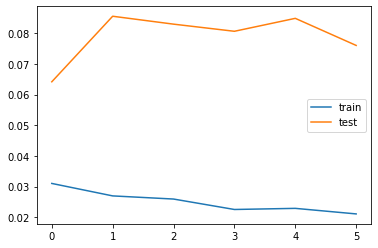

(121, 7)
(121, 7)
(121, 7)
score_train: [209.262] 177.4, 202.2, 201.4, 209.0, 204.7, 229.8, 235.1
(29, 1, 35)
score_test: [413.295] 322.3, 371.5, 192.9, 286.1, 533.5, 560.0, 486.2

RMSE test:  413.295366083892 


Units CNN1:  190 ,Sequence size:  7
(121, 1, 35)
Epoch 1/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0317 - val_loss: 0.1007
Epoch 2/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0264 - val_loss: 0.0956
Epoch 3/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0244 - val_loss: 0.0841
Epoch 4/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0237 - val_loss: 0.0831
Epoch 5/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0210 - val_loss: 0.0781
Epoch 6/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0219 - val_loss: 0.0801
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              P

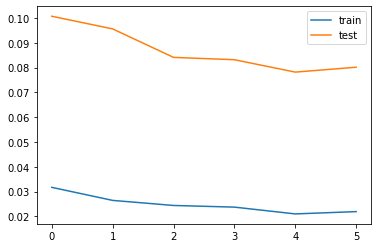

(121, 7)
(121, 7)
(121, 7)
score_train: [210.037] 181.7, 210.3, 206.6, 208.6, 227.2, 215.6, 217.5
(29, 1, 35)
score_test: [424.288] 332.4, 229.8, 196.2, 284.4, 586.7, 560.4, 565.0

RMSE test:  424.2876435069942 


Units CNN1:  255 ,Sequence size:  7
(121, 1, 35)
Epoch 1/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0326 - val_loss: 0.0885
Epoch 2/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0254 - val_loss: 0.0889
Epoch 3/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0225 - val_loss: 0.0890
Epoch 4/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0227 - val_loss: 0.0693
Epoch 5/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0242 - val_loss: 0.0759
Epoch 6/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0212 - val_loss: 0.0796
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              

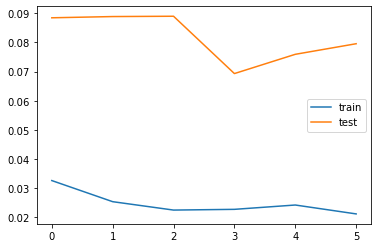

(121, 7)
(121, 7)
(121, 7)
score_train: [203.105] 183.1, 200.6, 206.9, 208.9, 200.3, 207.2, 213.4
(29, 1, 35)
score_test: [422.842] 395.5, 318.4, 163.4, 343.3, 501.2, 523.2, 569.4

RMSE test:  422.842245685504 


Units CNN1:  255 ,Sequence size:  7
(121, 1, 35)
Epoch 1/6
121/121 [==============================] - 0s 4ms/step - loss: 0.0347 - val_loss: 0.0972
Epoch 2/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0277 - val_loss: 0.1096
Epoch 3/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0251 - val_loss: 0.0832
Epoch 4/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0237 - val_loss: 0.0900
Epoch 5/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0228 - val_loss: 0.0777
Epoch 6/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0213 - val_loss: 0.0608
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              P

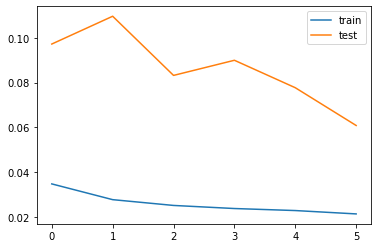

(121, 7)
(121, 7)
(121, 7)
score_train: [224.479] 184.5, 203.2, 236.4, 250.3, 198.8, 239.1, 249.4
(29, 1, 35)
score_test: [369.680] 373.1, 331.5, 177.0, 175.6, 520.3, 442.3, 423.2

RMSE test:  369.68009587886786 


Units CNN1:  191 ,Sequence size:  7
(121, 1, 35)
Epoch 1/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0338 - val_loss: 0.0726
Epoch 2/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0269 - val_loss: 0.0717
Epoch 3/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0259 - val_loss: 0.0634
Epoch 4/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0231 - val_loss: 0.0730
Epoch 5/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0236 - val_loss: 0.0799
Epoch 6/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0203 - val_loss: 0.0796
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape             

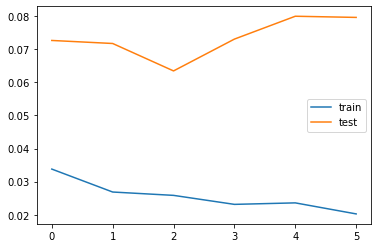

(121, 7)
(121, 7)
(121, 7)
score_train: [209.132] 199.6, 197.4, 221.0, 216.6, 207.4, 207.4, 213.4
(29, 1, 35)
score_test: [422.881] 457.5, 260.6, 253.8, 328.9, 609.0, 489.3, 437.8

RMSE test:  422.8814063502491 


Units CNN1:  255 ,Sequence size:  7
(121, 1, 35)
Epoch 1/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0347 - val_loss: 0.0893
Epoch 2/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0248 - val_loss: 0.1059
Epoch 3/6
121/121 [==============================] - 0s 3ms/step - loss: 0.0245 - val_loss: 0.0748
Epoch 4/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0226 - val_loss: 0.0766
Epoch 5/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0216 - val_loss: 0.0716
Epoch 6/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0225 - val_loss: 0.0778
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              

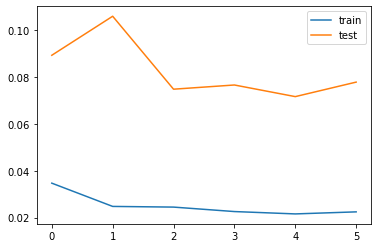

(121, 7)
(121, 7)
(121, 7)
score_train: [201.848] 191.0, 203.0, 200.8, 204.7, 199.1, 203.0, 210.7
(29, 1, 35)
score_test: [418.184] 341.9, 290.6, 194.9, 335.1, 527.6, 512.9, 575.3

RMSE test:  418.1839894642971 


Units CNN1:  255 ,Sequence size:  7
(121, 1, 35)
Epoch 1/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0335 - val_loss: 0.1105
Epoch 2/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0256 - val_loss: 0.1088
Epoch 3/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0257 - val_loss: 0.0994
Epoch 4/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0237 - val_loss: 0.1027
Epoch 5/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0229 - val_loss: 0.0701
Epoch 6/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0221 - val_loss: 0.0775
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              

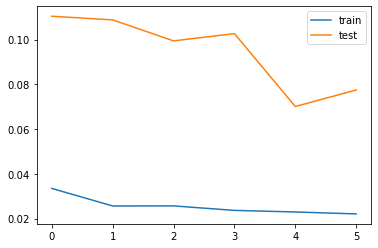

(121, 7)
(121, 7)
(121, 7)
score_train: [203.919] 179.5, 205.0, 213.5, 204.0, 204.6, 207.9, 211.1
(29, 1, 35)
score_test: [417.279] 350.2, 256.7, 178.2, 322.8, 585.7, 510.9, 538.9

RMSE test:  417.2794336735661 


Units CNN1:  223 ,Sequence size:  7
(121, 1, 35)
Epoch 1/6
121/121 [==============================] - 0s 3ms/step - loss: 0.0313 - val_loss: 0.0818
Epoch 2/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0270 - val_loss: 0.0779
Epoch 3/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0235 - val_loss: 0.0682
Epoch 4/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0238 - val_loss: 0.0903
Epoch 5/6
121/121 [==============================] - 0s 3ms/step - loss: 0.0226 - val_loss: 0.0915
Epoch 6/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0211 - val_loss: 0.0610
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              

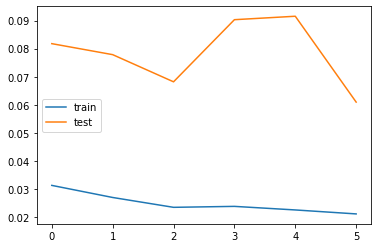

(121, 7)
(121, 7)
(121, 7)
score_train: [208.090] 186.0, 200.7, 200.8, 207.9, 201.1, 215.0, 241.0
(29, 1, 35)
score_test: [370.108] 334.2, 324.1, 173.7, 332.4, 493.5, 434.0, 411.9

RMSE test:  370.10815813875297 


Units CNN1:  255 ,Sequence size:  7
(121, 1, 35)
Epoch 1/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0326 - val_loss: 0.0837
Epoch 2/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0282 - val_loss: 0.0761
Epoch 3/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0248 - val_loss: 0.0726
Epoch 4/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0226 - val_loss: 0.0757
Epoch 5/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0231 - val_loss: 0.0563
Epoch 6/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0221 - val_loss: 0.0776
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape             

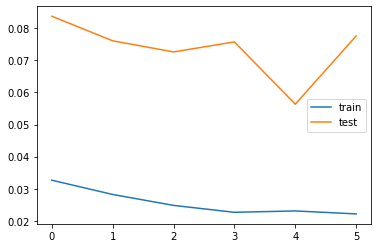

(121, 7)
(121, 7)
(121, 7)
score_train: [206.213] 182.5, 205.3, 206.4, 207.8, 208.3, 215.4, 216.0
(29, 1, 35)
score_test: [417.523] 343.9, 340.5, 218.8, 345.2, 536.7, 520.3, 510.2

RMSE test:  417.5232735232572 


Units CNN1:  215 ,Sequence size:  7
(121, 1, 35)
Epoch 1/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0304 - val_loss: 0.1044
Epoch 2/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0261 - val_loss: 0.1035
Epoch 3/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0246 - val_loss: 0.0898
Epoch 4/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0222 - val_loss: 0.0829
Epoch 5/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0223 - val_loss: 0.0867
Epoch 6/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0227 - val_loss: 0.0596
Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              

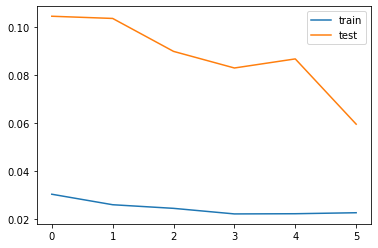

(121, 7)
(121, 7)
(121, 7)
score_train: [205.456] 183.3, 204.0, 204.0, 207.3, 216.2, 205.0, 216.6
(29, 1, 35)
score_test: [365.852] 314.5, 228.0, 151.9, 216.3, 461.6, 520.6, 481.8

RMSE test:  365.8518005199333 

gen	nevals	avg    	std    	min    	max    
0  	10    	382.382	20.2687	365.852	413.295

Units CNN1:  255 ,Sequence size:  7
(121, 1, 35)
Epoch 1/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0320 - val_loss: 0.0941
Epoch 2/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0275 - val_loss: 0.0726
Epoch 3/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0244 - val_loss: 0.0913
Epoch 4/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0229 - val_loss: 0.1015
Epoch 5/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0227 - val_loss: 0.0711
Epoch 6/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0206 - val_loss: 0.0680
Model: "sequential_10"
__________________________________

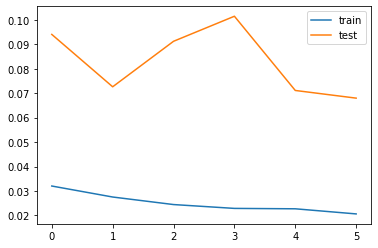

(121, 7)
(121, 7)
(121, 7)
score_train: [205.035] 185.0, 207.3, 211.8, 205.8, 208.6, 203.3, 212.2
(29, 1, 35)
score_test: [390.836] 382.5, 303.6, 160.5, 227.4, 495.0, 487.0, 520.7

RMSE test:  390.83579554372926 


Units CNN1:  255 ,Sequence size:  7
(121, 1, 35)
Epoch 1/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0349 - val_loss: 0.0821
Epoch 2/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0241 - val_loss: 0.1019
Epoch 3/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0250 - val_loss: 0.0675
Epoch 4/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0230 - val_loss: 0.0802
Epoch 5/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0226 - val_loss: 0.0935
Epoch 6/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0213 - val_loss: 0.0591
Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape            

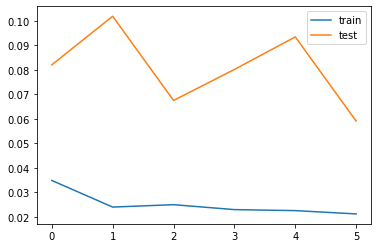

(121, 7)
(121, 7)
(121, 7)
score_train: [213.657] 179.2, 229.3, 207.0, 232.2, 219.6, 205.6, 218.1
(29, 1, 35)
score_test: [364.492] 390.6, 205.7, 178.2, 138.4, 442.2, 470.0, 517.5

RMSE test:  364.4924850923079 


Units CNN1:  255 ,Sequence size:  7
(121, 1, 35)
Epoch 1/6
121/121 [==============================] - 1s 4ms/step - loss: 0.0305 - val_loss: 0.0963
Epoch 2/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0259 - val_loss: 0.0923
Epoch 3/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0243 - val_loss: 0.0864
Epoch 4/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0229 - val_loss: 0.0794
Epoch 5/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0217 - val_loss: 0.0938
Epoch 6/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0222 - val_loss: 0.1003
Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape             

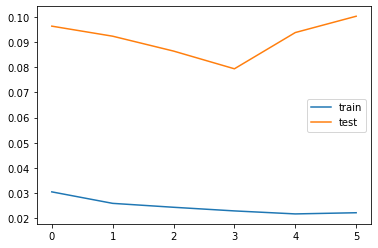

(121, 7)
(121, 7)
(121, 7)
score_train: [215.842] 193.4, 210.9, 222.8, 204.6, 217.7, 217.6, 240.6
(29, 1, 35)
score_test: [474.639] 431.8, 352.1, 226.5, 315.2, 586.0, 611.1, 631.7

RMSE test:  474.63947125248484 


Units CNN1:  255 ,Sequence size:  7
(121, 1, 35)
Epoch 1/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0325 - val_loss: 0.1170
Epoch 2/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0287 - val_loss: 0.1010
Epoch 3/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0243 - val_loss: 0.0896
Epoch 4/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0242 - val_loss: 0.0879
Epoch 5/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0225 - val_loss: 0.0575
Epoch 6/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0216 - val_loss: 0.0679
Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape            

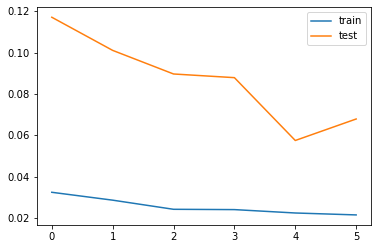

(121, 7)
(121, 7)
(121, 7)
score_train: [206.430] 191.5, 222.2, 200.5, 206.7, 198.4, 200.2, 223.4
(29, 1, 35)
score_test: [390.608] 362.9, 273.1, 180.9, 342.1, 477.7, 504.1, 479.3

RMSE test:  390.6077518056199 


Units CNN1:  175 ,Sequence size:  7
(121, 1, 35)
Epoch 1/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0353 - val_loss: 0.0924
Epoch 2/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0268 - val_loss: 0.0825
Epoch 3/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0247 - val_loss: 0.0736
Epoch 4/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0232 - val_loss: 0.0792
Epoch 5/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0221 - val_loss: 0.0614
Epoch 6/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0219 - val_loss: 0.0638
Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape             

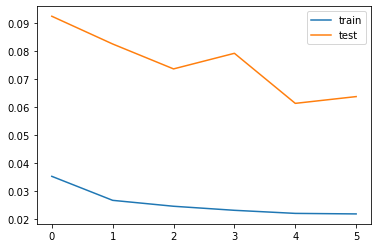

(121, 7)
(121, 7)
(121, 7)
score_train: [206.609] 183.9, 197.9, 204.3, 220.9, 212.2, 210.0, 214.9
(29, 1, 35)
score_test: [378.538] 383.2, 354.1, 218.0, 214.0, 478.8, 419.7, 481.8

RMSE test:  378.53814806720374 


Units CNN1:  243 ,Sequence size:  7
(121, 1, 35)
Epoch 1/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0344 - val_loss: 0.1100
Epoch 2/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0282 - val_loss: 0.0864
Epoch 3/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0236 - val_loss: 0.0864
Epoch 4/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0220 - val_loss: 0.0571
Epoch 5/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0229 - val_loss: 0.0674
Epoch 6/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0226 - val_loss: 0.0708
Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape            

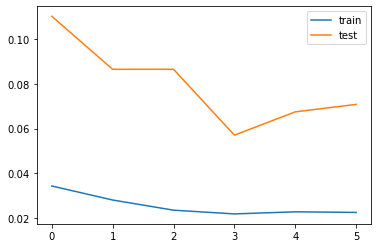

(121, 7)
(121, 7)
(121, 7)
score_train: [200.248] 179.9, 203.2, 199.2, 201.7, 196.7, 208.4, 211.2
(29, 1, 35)
score_test: [398.773] 319.8, 229.4, 202.6, 286.5, 514.9, 489.2, 575.0

RMSE test:  398.7731514433024 


Units CNN1:  235 ,Sequence size:  7
(121, 1, 35)
Epoch 1/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0317 - val_loss: 0.1006
Epoch 2/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0260 - val_loss: 0.0840
Epoch 3/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0235 - val_loss: 0.0981
Epoch 4/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0234 - val_loss: 0.0685
Epoch 5/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0208 - val_loss: 0.0703
Epoch 6/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0227 - val_loss: 0.0556
Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape             

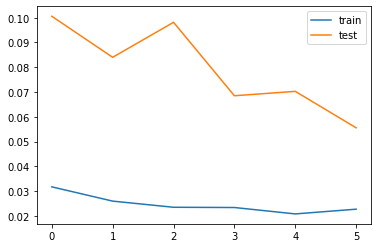

(121, 7)
(121, 7)
(121, 7)
score_train: [218.138] 212.6, 202.7, 212.0, 223.6, 206.5, 251.0, 215.0
(29, 1, 35)
score_test: [353.319] 254.8, 270.5, 146.5, 288.8, 471.7, 388.5, 507.4

RMSE test:  353.3185302381285 


Units CNN1:  255 ,Sequence size:  7
(121, 1, 35)
Epoch 1/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0331 - val_loss: 0.0959
Epoch 2/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0261 - val_loss: 0.0777
Epoch 3/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0237 - val_loss: 0.0864
Epoch 4/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0239 - val_loss: 0.0918
Epoch 5/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0229 - val_loss: 0.0758
Epoch 6/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0216 - val_loss: 0.0848
Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape             

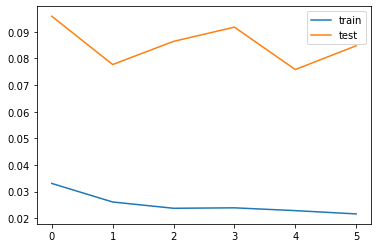

(121, 7)
(121, 7)
(121, 7)
score_train: [206.878] 185.7, 200.8, 221.6, 212.4, 211.5, 203.4, 210.9
(29, 1, 35)
score_test: [436.418] 407.5, 327.6, 247.9, 358.4, 581.6, 473.4, 554.6

RMSE test:  436.4176718142927 


Units CNN1:  255 ,Sequence size:  7
(121, 1, 35)
Epoch 1/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0352 - val_loss: 0.0805
Epoch 2/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0251 - val_loss: 0.0709
Epoch 3/6
121/121 [==============================] - 0s 3ms/step - loss: 0.0245 - val_loss: 0.0672
Epoch 4/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0233 - val_loss: 0.0649
Epoch 5/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0236 - val_loss: 0.0830
Epoch 6/6
121/121 [==============================] - 0s 3ms/step - loss: 0.0211 - val_loss: 0.0933
Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape             

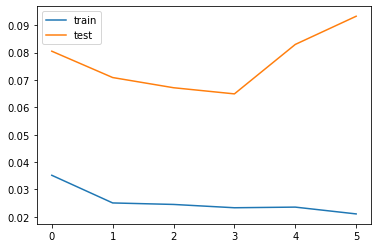

(121, 7)
(121, 7)
(121, 7)
score_train: [224.324] 180.9, 202.8, 259.5, 212.0, 263.9, 207.8, 231.0
(29, 1, 35)
score_test: [457.749] 335.5, 342.2, 320.4, 306.1, 605.5, 546.1, 613.1

RMSE test:  457.7488161479695 

1  	9     	366.157	16.5241	353.319	413.295

Units CNN1:  255 ,Sequence size:  7
(121, 1, 35)
Epoch 1/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0318 - val_loss: 0.1185
Epoch 2/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0269 - val_loss: 0.0897
Epoch 3/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0237 - val_loss: 0.0924
Epoch 4/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0227 - val_loss: 0.0809
Epoch 5/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0223 - val_loss: 0.0975
Epoch 6/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0214 - val_loss: 0.0690
Model: "sequential_19"
_________________________________________________________________
Layer (type

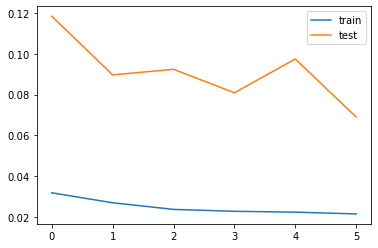

(121, 7)
(121, 7)
(121, 7)
score_train: [202.614] 184.9, 195.7, 203.8, 215.2, 200.2, 199.9, 216.7
(29, 1, 35)
score_test: [393.834] 342.3, 293.0, 190.4, 216.0, 530.3, 499.2, 519.0

RMSE test:  393.83377469654573 


Units CNN1:  255 ,Sequence size:  7
(121, 1, 35)
Epoch 1/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0312 - val_loss: 0.0782
Epoch 2/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0274 - val_loss: 0.0665
Epoch 3/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0257 - val_loss: 0.0778
Epoch 4/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0229 - val_loss: 0.0848
Epoch 5/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0222 - val_loss: 0.0797
Epoch 6/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0209 - val_loss: 0.0718
Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape            

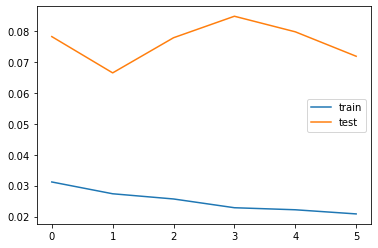

(121, 7)
(121, 7)
(121, 7)
score_train: [203.516] 178.7, 201.2, 208.9, 208.1, 200.1, 214.0, 211.6
(29, 1, 35)
score_test: [401.745] 361.1, 339.5, 211.3, 276.1, 502.6, 513.1, 497.3

RMSE test:  401.7448382153955 


Units CNN1:  175 ,Sequence size:  7
(121, 1, 35)
Epoch 1/6
121/121 [==============================] - 1s 5ms/step - loss: 0.0341 - val_loss: 0.1061
Epoch 2/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0253 - val_loss: 0.0865
Epoch 3/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0235 - val_loss: 0.0620
Epoch 4/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0248 - val_loss: 0.0821
Epoch 5/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0218 - val_loss: 0.0638
Epoch 6/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0225 - val_loss: 0.0631
Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape             

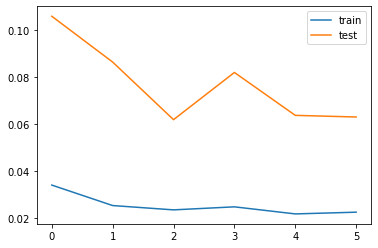

(121, 7)
(121, 7)
(121, 7)
score_train: [204.844] 189.1, 203.0, 202.3, 209.2, 205.3, 209.0, 215.0
(29, 1, 35)
score_test: [376.562] 388.5, 284.2, 178.0, 274.2, 441.0, 474.8, 483.8

RMSE test:  376.56218014549796 


Units CNN1:  175 ,Sequence size:  7
(121, 1, 35)
Epoch 1/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0313 - val_loss: 0.1085
Epoch 2/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0271 - val_loss: 0.1048
Epoch 3/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0249 - val_loss: 0.0892
Epoch 4/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0237 - val_loss: 0.0568
Epoch 5/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0222 - val_loss: 0.0740
Epoch 6/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0214 - val_loss: 0.0660
Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape            

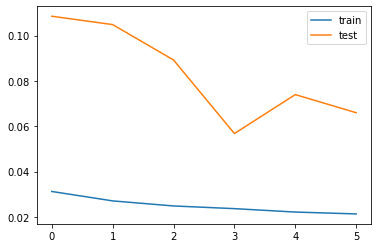

(121, 7)
(121, 7)
(121, 7)
score_train: [211.232] 197.3, 214.3, 212.4, 226.9, 207.9, 202.6, 215.9
(29, 1, 35)
score_test: [385.042] 365.6, 362.5, 180.3, 203.3, 496.0, 422.5, 523.7

RMSE test:  385.0424528214026 


Units CNN1:  243 ,Sequence size:  7
(121, 1, 35)
Epoch 1/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0336 - val_loss: 0.1093
Epoch 2/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0272 - val_loss: 0.0770
Epoch 3/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0248 - val_loss: 0.0769
Epoch 4/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0234 - val_loss: 0.0842
Epoch 5/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0224 - val_loss: 0.0749
Epoch 6/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0222 - val_loss: 0.0823
Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape             

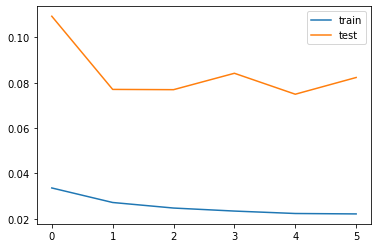

(121, 7)
(121, 7)
(121, 7)
score_train: [205.923] 201.1, 201.7, 204.2, 203.4, 203.7, 208.0, 218.7
(29, 1, 35)
score_test: [430.013] 407.8, 335.4, 191.0, 274.4, 561.5, 534.7, 550.2

RMSE test:  430.01258369284625 


Units CNN1:  255 ,Sequence size:  7
(121, 1, 35)
Epoch 1/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0308 - val_loss: 0.0914
Epoch 2/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0277 - val_loss: 0.0814
Epoch 3/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0242 - val_loss: 0.0840
Epoch 4/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0233 - val_loss: 0.0872
Epoch 5/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0225 - val_loss: 0.0926
Epoch 6/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0234 - val_loss: 0.0846
Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape            

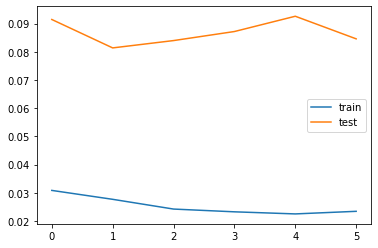

(121, 7)
(121, 7)
(121, 7)
score_train: [206.918] 184.8, 205.6, 202.3, 200.1, 207.5, 219.8, 225.7
(29, 1, 35)
score_test: [435.910] 399.8, 324.8, 211.1, 233.2, 607.8, 533.6, 558.4

RMSE test:  435.91001593024833 

2  	6     	356.671	5.12055	353.319	364.492

Units CNN1:  255 ,Sequence size:  7
(121, 1, 35)
Epoch 1/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0305 - val_loss: 0.0882
Epoch 2/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0256 - val_loss: 0.1017
Epoch 3/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0246 - val_loss: 0.0825
Epoch 4/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0237 - val_loss: 0.0855
Epoch 5/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0216 - val_loss: 0.0739
Epoch 6/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0226 - val_loss: 0.0773
Model: "sequential_25"
_________________________________________________________________
Layer (typ

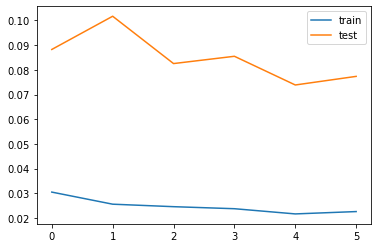

(121, 7)
(121, 7)
(121, 7)
score_train: [203.647] 183.1, 198.3, 203.5, 207.9, 210.5, 208.1, 212.6
(29, 1, 35)
score_test: [416.886] 333.6, 262.6, 169.7, 280.2, 609.8, 546.4, 508.5

RMSE test:  416.88591851271497 


Units CNN1:  255 ,Sequence size:  7
(121, 1, 35)
Epoch 1/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0320 - val_loss: 0.1118
Epoch 2/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0261 - val_loss: 0.0701
Epoch 3/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0254 - val_loss: 0.0818
Epoch 4/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0226 - val_loss: 0.0811
Epoch 5/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0219 - val_loss: 0.0644
Epoch 6/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0212 - val_loss: 0.0615
Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape            

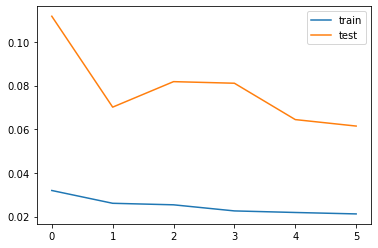

(121, 7)
(121, 7)
(121, 7)
score_train: [210.253] 211.3, 213.4, 201.1, 203.7, 210.5, 212.1, 219.1
(29, 1, 35)
score_test: [371.668] 298.4, 298.4, 173.4, 333.4, 444.5, 458.2, 490.1

RMSE test:  371.66838352414106 


Units CNN1:  251 ,Sequence size:  7
(121, 1, 35)
Epoch 1/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0377 - val_loss: 0.0958
Epoch 2/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0271 - val_loss: 0.1091
Epoch 3/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0265 - val_loss: 0.0833
Epoch 4/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0225 - val_loss: 0.0583
Epoch 5/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0220 - val_loss: 0.0798
Epoch 6/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0233 - val_loss: 0.0848
Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape            

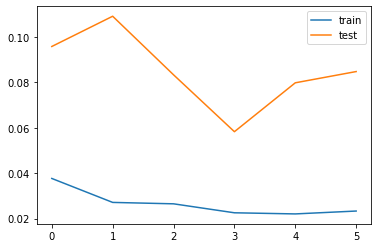

(121, 7)
(121, 7)
(121, 7)
score_train: [209.722] 185.9, 211.8, 232.3, 203.0, 207.6, 204.9, 219.7
(29, 1, 35)
score_test: [436.443] 328.1, 362.2, 230.9, 309.9, 522.1, 531.8, 624.3

RMSE test:  436.44335618558813 


Units CNN1:  255 ,Sequence size:  7
(121, 1, 35)
Epoch 1/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0316 - val_loss: 0.0915
Epoch 2/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0255 - val_loss: 0.0545
Epoch 3/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0247 - val_loss: 0.0794
Epoch 4/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0239 - val_loss: 0.0853
Epoch 5/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0225 - val_loss: 0.0763
Epoch 6/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0228 - val_loss: 0.0777
Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape            

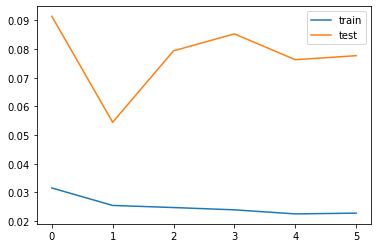

(121, 7)
(121, 7)
(121, 7)
score_train: [204.347] 183.8, 204.8, 204.3, 221.9, 202.8, 202.5, 208.4
(29, 1, 35)
score_test: [417.843] 387.6, 337.6, 222.1, 368.0, 477.9, 522.4, 521.5

RMSE test:  417.8429109935313 


Units CNN1:  255 ,Sequence size:  7
(121, 1, 35)
Epoch 1/6
121/121 [==============================] - 0s 4ms/step - loss: 0.0338 - val_loss: 0.1069
Epoch 2/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0253 - val_loss: 0.0820
Epoch 3/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0241 - val_loss: 0.1128
Epoch 4/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0243 - val_loss: 0.0634
Epoch 5/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0215 - val_loss: 0.0788
Epoch 6/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0214 - val_loss: 0.0848
Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape             

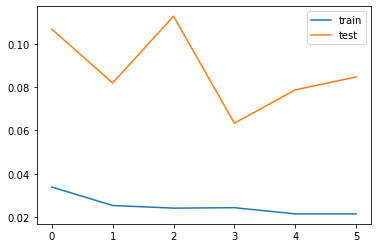

(121, 7)
(121, 7)
(121, 7)
score_train: [212.992] 200.6, 217.5, 198.9, 223.7, 209.1, 211.8, 227.6
(29, 1, 35)
score_test: [436.390] 459.7, 319.7, 172.6, 294.0, 517.0, 535.8, 590.7

RMSE test:  436.3899520927869 


Units CNN1:  255 ,Sequence size:  7
(121, 1, 35)
Epoch 1/6
121/121 [==============================] - 1s 5ms/step - loss: 0.0329 - val_loss: 0.1119
Epoch 2/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0282 - val_loss: 0.1164
Epoch 3/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0241 - val_loss: 0.0853
Epoch 4/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0237 - val_loss: 0.0744
Epoch 5/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0229 - val_loss: 0.0881
Epoch 6/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0237 - val_loss: 0.0813
Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape             

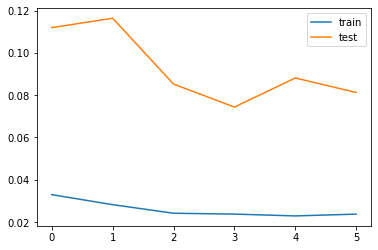

(121, 7)
(121, 7)
(121, 7)
score_train: [203.212] 180.0, 207.4, 204.4, 204.8, 198.7, 208.0, 217.1
(29, 1, 35)
score_test: [427.368] 374.5, 321.3, 216.6, 343.6, 507.9, 539.3, 566.8

RMSE test:  427.3683620364292 


Units CNN1:  255 ,Sequence size:  7
(121, 1, 35)
Epoch 1/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0319 - val_loss: 0.0905
Epoch 2/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0254 - val_loss: 0.0810
Epoch 3/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0233 - val_loss: 0.0750
Epoch 4/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0226 - val_loss: 0.0659
Epoch 5/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0218 - val_loss: 0.0881
Epoch 6/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0216 - val_loss: 0.0712
Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape             

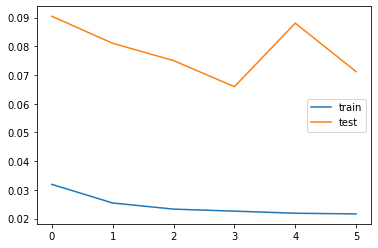

(121, 7)
(121, 7)
(121, 7)
score_train: [211.097] 196.6, 208.8, 219.4, 213.3, 216.2, 212.4, 210.3
(29, 1, 35)
score_test: [399.881] 457.6, 275.8, 178.6, 308.3, 459.5, 475.0, 519.7

RMSE test:  399.88093646423056 


Units CNN1:  253 ,Sequence size:  7
(121, 1, 35)
Epoch 1/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0346 - val_loss: 0.1051
Epoch 2/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0268 - val_loss: 0.0928
Epoch 3/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0251 - val_loss: 0.0863
Epoch 4/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0236 - val_loss: 0.0975
Epoch 5/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0217 - val_loss: 0.0825
Epoch 6/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0230 - val_loss: 0.0781
Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape            

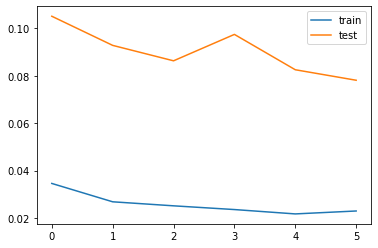

(121, 7)
(121, 7)
(121, 7)
score_train: [202.777] 186.4, 197.5, 204.3, 203.8, 209.9, 200.9, 215.5
(29, 1, 35)
score_test: [418.959] 310.4, 333.2, 215.2, 373.5, 618.4, 487.2, 464.5

RMSE test:  418.95933906234495 

3  	8     	354.436	3.35219	353.319	364.492

Units CNN1:  221 ,Sequence size:  7
(121, 1, 35)
Epoch 1/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0382 - val_loss: 0.1190
Epoch 2/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0293 - val_loss: 0.0926
Epoch 3/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0243 - val_loss: 0.0890
Epoch 4/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0238 - val_loss: 0.0844
Epoch 5/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0230 - val_loss: 0.0803
Epoch 6/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0209 - val_loss: 0.0861
Model: "sequential_33"
_________________________________________________________________
Layer (typ

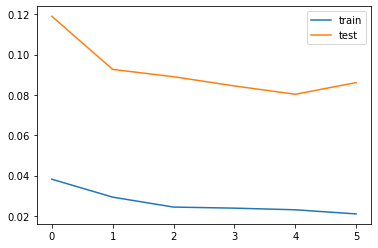

(121, 7)
(121, 7)
(121, 7)
score_train: [205.376] 184.3, 197.1, 207.2, 202.3, 202.1, 225.2, 216.8
(29, 1, 35)
score_test: [439.817] 375.2, 350.1, 168.7, 328.1, 500.8, 608.1, 577.9

RMSE test:  439.81686059403125 


Units CNN1:  255 ,Sequence size:  7
(121, 1, 35)
Epoch 1/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0345 - val_loss: 0.1008
Epoch 2/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0266 - val_loss: 0.0745
Epoch 3/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0253 - val_loss: 0.0785
Epoch 4/6
121/121 [==============================] - 1s 5ms/step - loss: 0.0244 - val_loss: 0.0899
Epoch 5/6
121/121 [==============================] - 1s 5ms/step - loss: 0.0217 - val_loss: 0.0787
Epoch 6/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0224 - val_loss: 0.0819
Model: "sequential_34"
_________________________________________________________________
Layer (type)                 Output Shape            

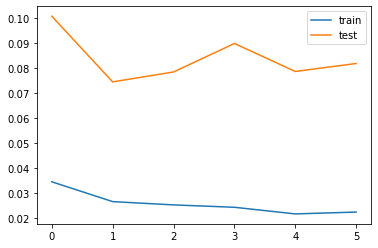

(121, 7)
(121, 7)
(121, 7)
score_train: [209.361] 227.0, 198.1, 202.4, 202.2, 206.6, 218.3, 209.4
(29, 1, 35)
score_test: [428.888] 463.6, 328.6, 165.2, 309.7, 502.7, 569.1, 514.7

RMSE test:  428.8875038135884 


Units CNN1:  255 ,Sequence size:  7
(121, 1, 35)
Epoch 1/6
121/121 [==============================] - 0s 3ms/step - loss: 0.0313 - val_loss: 0.0723
Epoch 2/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0260 - val_loss: 0.0689
Epoch 3/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0231 - val_loss: 0.0843
Epoch 4/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0232 - val_loss: 0.0822
Epoch 5/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0218 - val_loss: 0.0602
Epoch 6/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0233 - val_loss: 0.0699
Model: "sequential_35"
_________________________________________________________________
Layer (type)                 Output Shape             

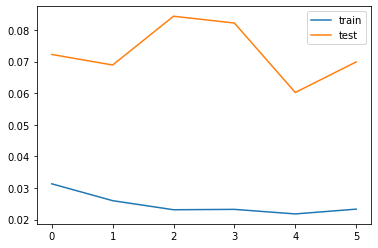

(121, 7)
(121, 7)
(121, 7)
score_train: [211.614] 195.0, 231.9, 223.5, 207.7, 203.5, 206.9, 210.6
(29, 1, 35)
score_test: [396.259] 271.0, 198.4, 181.2, 316.9, 548.9, 519.5, 531.0

RMSE test:  396.2587451912521 


Units CNN1:  127 ,Sequence size:  7
(121, 1, 35)
Epoch 1/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0325 - val_loss: 0.0776
Epoch 2/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0271 - val_loss: 0.1012
Epoch 3/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0233 - val_loss: 0.0972
Epoch 4/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0244 - val_loss: 0.0909
Epoch 5/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0239 - val_loss: 0.0974
Epoch 6/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0211 - val_loss: 0.0973
Model: "sequential_36"
_________________________________________________________________
Layer (type)                 Output Shape             

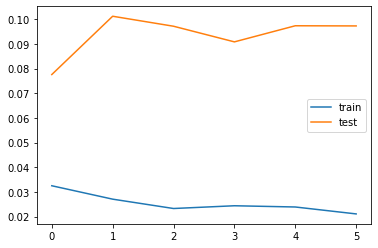

(121, 7)
(121, 7)
(121, 7)
score_train: [208.582] 182.8, 202.5, 210.3, 205.6, 207.5, 228.0, 220.4
(29, 1, 35)
score_test: [467.633] 330.1, 358.4, 256.7, 290.3, 619.0, 601.3, 631.2

RMSE test:  467.63257432568696 


Units CNN1:  255 ,Sequence size:  7
(121, 1, 35)
Epoch 1/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0315 - val_loss: 0.1080
Epoch 2/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0254 - val_loss: 0.0676
Epoch 3/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0241 - val_loss: 0.0859
Epoch 4/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0212 - val_loss: 0.0854
Epoch 5/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0221 - val_loss: 0.0997
Epoch 6/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0218 - val_loss: 0.0649
Model: "sequential_37"
_________________________________________________________________
Layer (type)                 Output Shape            

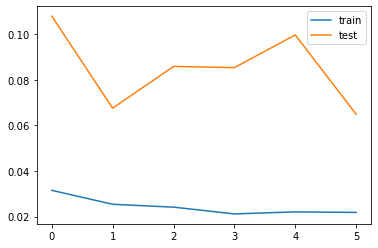

(121, 7)
(121, 7)
(121, 7)
score_train: [206.700] 188.8, 212.2, 212.4, 207.8, 202.9, 206.6, 215.1
(29, 1, 35)
score_test: [381.927] 308.6, 240.5, 209.7, 233.9, 595.7, 404.9, 500.5

RMSE test:  381.9265099531218 


Units CNN1:  255 ,Sequence size:  7
(121, 1, 35)
Epoch 1/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0308 - val_loss: 0.0894
Epoch 2/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0255 - val_loss: 0.1077
Epoch 3/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0240 - val_loss: 0.0903
Epoch 4/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0250 - val_loss: 0.0953
Epoch 5/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0213 - val_loss: 0.0875
Epoch 6/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0208 - val_loss: 0.0791
Model: "sequential_38"
_________________________________________________________________
Layer (type)                 Output Shape             

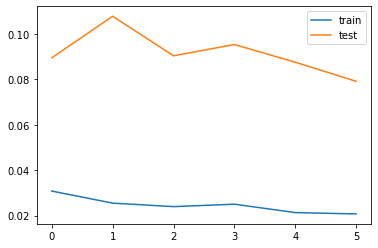

(121, 7)
(121, 7)
(121, 7)
score_train: [209.486] 231.0, 197.0, 221.0, 208.5, 199.1, 199.2, 208.4
(29, 1, 35)
score_test: [421.592] 260.8, 364.4, 192.5, 289.3, 544.8, 552.6, 566.1

RMSE test:  421.59203902964947 


Units CNN1:  255 ,Sequence size:  7
(121, 1, 35)
Epoch 1/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0308 - val_loss: 0.1133
Epoch 2/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0285 - val_loss: 0.0768
Epoch 3/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0248 - val_loss: 0.0849
Epoch 4/6
121/121 [==============================] - 0s 3ms/step - loss: 0.0225 - val_loss: 0.0651
Epoch 5/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0225 - val_loss: 0.0854
Epoch 6/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0218 - val_loss: 0.0868
Model: "sequential_39"
_________________________________________________________________
Layer (type)                 Output Shape            

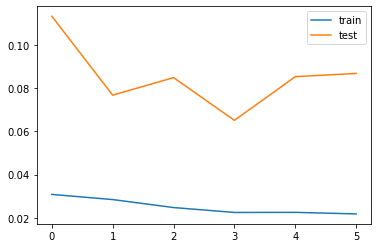

(121, 7)
(121, 7)
(121, 7)
score_train: [216.480] 178.8, 212.0, 220.1, 206.7, 257.6, 215.5, 217.1
(29, 1, 35)
score_test: [441.742] 354.1, 358.6, 221.1, 264.1, 620.6, 531.3, 570.9

RMSE test:  441.74214741076156 


Units CNN1:  255 ,Sequence size:  7
(121, 1, 35)
Epoch 1/6
121/121 [==============================] - 0s 3ms/step - loss: 0.0336 - val_loss: 0.1077
Epoch 2/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0245 - val_loss: 0.0735
Epoch 3/6
121/121 [==============================] - 0s 3ms/step - loss: 0.0249 - val_loss: 0.0677
Epoch 4/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0231 - val_loss: 0.0817
Epoch 5/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0221 - val_loss: 0.0673
Epoch 6/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0219 - val_loss: 0.0844
Model: "sequential_40"
_________________________________________________________________
Layer (type)                 Output Shape            

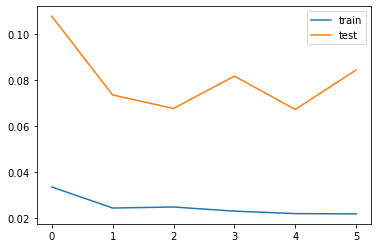

(121, 7)
(121, 7)
(121, 7)
score_train: [210.392] 188.2, 198.0, 199.7, 219.4, 220.4, 232.1, 211.6
(29, 1, 35)
score_test: [435.431] 366.5, 257.0, 203.8, 308.0, 611.8, 543.3, 566.5

RMSE test:  435.43095917181466 

4  	8     	353.319	0      	353.319	353.319

Units CNN1:  253 ,Sequence size:  7
(121, 1, 35)
Epoch 1/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0344 - val_loss: 0.0890
Epoch 2/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0271 - val_loss: 0.0742
Epoch 3/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0246 - val_loss: 0.0824
Epoch 4/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0226 - val_loss: 0.0854
Epoch 5/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0216 - val_loss: 0.0624
Epoch 6/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0221 - val_loss: 0.0673
Model: "sequential_41"
_________________________________________________________________
Layer (typ

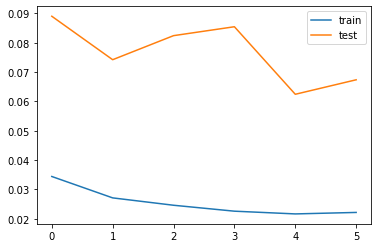

(121, 7)
(121, 7)
(121, 7)
score_train: [214.157] 191.7, 227.9, 231.7, 213.9, 218.8, 203.5, 208.9
(29, 1, 35)
score_test: [389.018] 416.4, 353.2, 246.3, 327.0, 379.5, 472.8, 475.4

RMSE test:  389.01816833879775 


Units CNN1:  255 ,Sequence size:  7
(121, 1, 35)
Epoch 1/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0317 - val_loss: 0.0825
Epoch 2/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0251 - val_loss: 0.0868
Epoch 3/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0240 - val_loss: 0.0899
Epoch 4/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0228 - val_loss: 0.0718
Epoch 5/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0222 - val_loss: 0.0814
Epoch 6/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0216 - val_loss: 0.0691
Model: "sequential_42"
_________________________________________________________________
Layer (type)                 Output Shape            

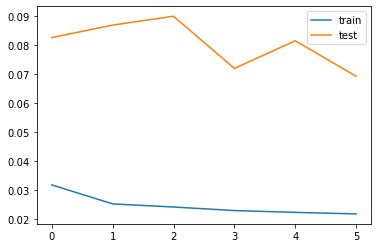

(121, 7)
(121, 7)
(121, 7)
score_train: [200.244] 184.4, 197.4, 203.4, 207.9, 194.3, 203.7, 209.3
(29, 1, 35)
score_test: [394.166] 338.3, 305.0, 205.3, 284.9, 522.7, 488.9, 494.5

RMSE test:  394.1664563432477 


Units CNN1:  239 ,Sequence size:  7
(121, 1, 35)
Epoch 1/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0344 - val_loss: 0.1150
Epoch 2/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0264 - val_loss: 0.1057
Epoch 3/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0262 - val_loss: 0.0967
Epoch 4/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0236 - val_loss: 0.0680
Epoch 5/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0233 - val_loss: 0.0748
Epoch 6/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0217 - val_loss: 0.0763
Model: "sequential_43"
_________________________________________________________________
Layer (type)                 Output Shape             

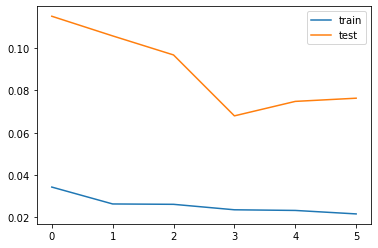

(121, 7)
(121, 7)
(121, 7)
score_train: [210.012] 224.4, 203.8, 209.0, 208.2, 202.1, 209.2, 212.7
(29, 1, 35)
score_test: [414.113] 320.1, 342.2, 169.5, 262.4, 529.5, 548.2, 550.0

RMSE test:  414.11311116913197 


Units CNN1:  255 ,Sequence size:  7
(121, 1, 35)
Epoch 1/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0318 - val_loss: 0.1089
Epoch 2/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0254 - val_loss: 0.0783
Epoch 3/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0255 - val_loss: 0.0745
Epoch 4/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0246 - val_loss: 0.0794
Epoch 5/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0216 - val_loss: 0.0939
Epoch 6/6
121/121 [==============================] - 0s 3ms/step - loss: 0.0219 - val_loss: 0.0934
Model: "sequential_44"
_________________________________________________________________
Layer (type)                 Output Shape            

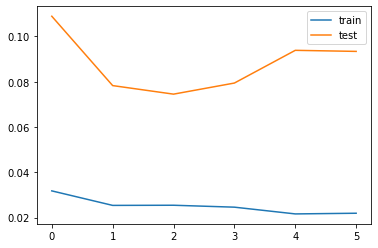

(121, 7)
(121, 7)
(121, 7)
score_train: [204.392] 180.7, 196.9, 210.2, 213.6, 207.2, 205.2, 214.9
(29, 1, 35)
score_test: [458.098] 362.4, 383.4, 243.8, 378.1, 612.6, 500.5, 602.0

RMSE test:  458.0978108478106 


Units CNN1:  249 ,Sequence size:  7
(121, 1, 35)
Epoch 1/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0335 - val_loss: 0.0961
Epoch 2/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0268 - val_loss: 0.0883
Epoch 3/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0238 - val_loss: 0.0677
Epoch 4/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0232 - val_loss: 0.0817
Epoch 5/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0213 - val_loss: 0.0870
Epoch 6/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0218 - val_loss: 0.0734
Model: "sequential_45"
_________________________________________________________________
Layer (type)                 Output Shape             

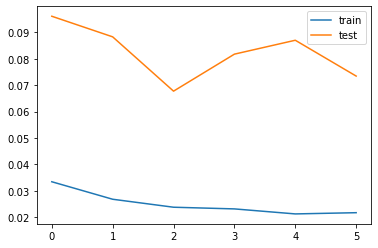

(121, 7)
(121, 7)
(121, 7)
score_train: [208.229] 191.7, 218.7, 210.6, 217.2, 199.6, 207.9, 210.6
(29, 1, 35)
score_test: [406.244] 438.0, 348.0, 190.3, 362.0, 463.9, 449.8, 507.5

RMSE test:  406.2443082280852 


Units CNN1:  255 ,Sequence size:  7
(121, 1, 35)
Epoch 1/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0351 - val_loss: 0.1140
Epoch 2/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0252 - val_loss: 0.0751
Epoch 3/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0246 - val_loss: 0.0978
Epoch 4/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0221 - val_loss: 0.0723
Epoch 5/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0239 - val_loss: 0.1063
Epoch 6/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0218 - val_loss: 0.0827
Model: "sequential_46"
_________________________________________________________________
Layer (type)                 Output Shape             

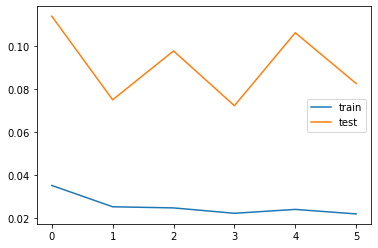

(121, 7)
(121, 7)
(121, 7)
score_train: [202.369] 186.6, 201.8, 198.5, 199.5, 208.9, 203.9, 216.2
(29, 1, 35)
score_test: [430.948] 394.9, 345.0, 205.4, 267.5, 511.5, 557.1, 582.4

RMSE test:  430.9482553261469 


Units CNN1:  255 ,Sequence size:  7
(121, 1, 35)
Epoch 1/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0333 - val_loss: 0.0898
Epoch 2/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0256 - val_loss: 0.0678
Epoch 3/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0246 - val_loss: 0.0864
Epoch 4/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0230 - val_loss: 0.0717
Epoch 5/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0231 - val_loss: 0.0793
Epoch 6/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0209 - val_loss: 0.0658
Model: "sequential_47"
_________________________________________________________________
Layer (type)                 Output Shape             

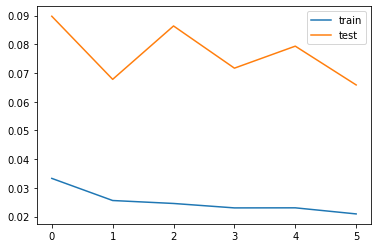

(121, 7)
(121, 7)
(121, 7)
score_train: [216.375] 183.7, 194.6, 283.6, 208.2, 200.7, 201.6, 226.7
(29, 1, 35)
score_test: [384.646] 355.2, 337.2, 163.7, 263.1, 537.3, 476.4, 429.2

RMSE test:  384.64611376279527 


Units CNN1:  255 ,Sequence size:  7
(121, 1, 35)
Epoch 1/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0305 - val_loss: 0.0864
Epoch 2/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0275 - val_loss: 0.0907
Epoch 3/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0251 - val_loss: 0.0755
Epoch 4/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0237 - val_loss: 0.0788
Epoch 5/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0225 - val_loss: 0.0803
Epoch 6/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0209 - val_loss: 0.0767
Model: "sequential_48"
_________________________________________________________________
Layer (type)                 Output Shape            

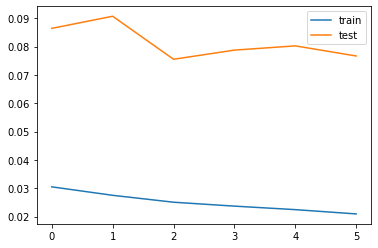

(121, 7)
(121, 7)
(121, 7)
score_train: [204.681] 187.0, 202.0, 215.2, 200.0, 205.3, 201.6, 220.0
(29, 1, 35)
score_test: [415.147] 386.6, 307.0, 185.7, 228.8, 535.0, 506.3, 577.3

RMSE test:  415.1467318108506 


Units CNN1:  255 ,Sequence size:  7
(121, 1, 35)
Epoch 1/6
121/121 [==============================] - 1s 5ms/step - loss: 0.0318 - val_loss: 0.1043
Epoch 2/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0274 - val_loss: 0.1124
Epoch 3/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0251 - val_loss: 0.1052
Epoch 4/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0237 - val_loss: 0.0862
Epoch 5/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0228 - val_loss: 0.0951
Epoch 6/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0227 - val_loss: 0.0827
Model: "sequential_49"
_________________________________________________________________
Layer (type)                 Output Shape             

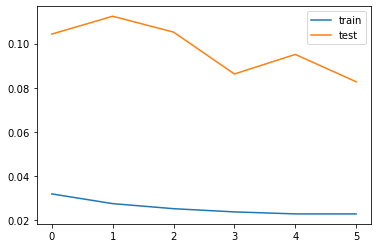

(121, 7)
(121, 7)
(121, 7)
score_train: [206.125] 186.5, 202.8, 206.8, 215.3, 208.8, 210.1, 211.4
(29, 1, 35)
score_test: [431.061] 412.3, 300.6, 210.9, 238.3, 492.0, 573.8, 606.4

RMSE test:  431.06064634374104 

5  	9     	353.319	0      	353.319	353.319

Units CNN1:  255 ,Sequence size:  7
(121, 1, 35)
Epoch 1/6
121/121 [==============================] - 0s 3ms/step - loss: 0.0312 - val_loss: 0.1255
Epoch 2/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0269 - val_loss: 0.0904
Epoch 3/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0241 - val_loss: 0.1043
Epoch 4/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0243 - val_loss: 0.0665
Epoch 5/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0228 - val_loss: 0.0821
Epoch 6/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0218 - val_loss: 0.0518
Model: "sequential_50"
_________________________________________________________________
Layer (typ

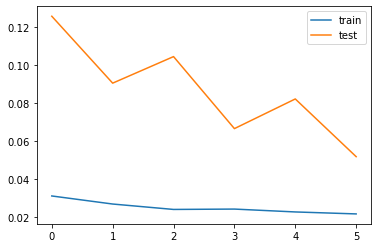

(121, 7)
(121, 7)
(121, 7)
score_train: [209.539] 186.9, 201.8, 215.3, 203.4, 200.4, 217.4, 237.8
(29, 1, 35)
score_test: [341.152] 251.7, 258.0, 145.1, 220.4, 466.6, 420.6, 469.6

RMSE test:  341.1519095791147 


Units CNN1:  247 ,Sequence size:  7
(121, 1, 35)
Epoch 1/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0334 - val_loss: 0.0906
Epoch 2/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0280 - val_loss: 0.1100
Epoch 3/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0229 - val_loss: 0.0907
Epoch 4/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0234 - val_loss: 0.0985
Epoch 5/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0235 - val_loss: 0.0851
Epoch 6/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0221 - val_loss: 0.0890
Model: "sequential_51"
_________________________________________________________________
Layer (type)                 Output Shape             

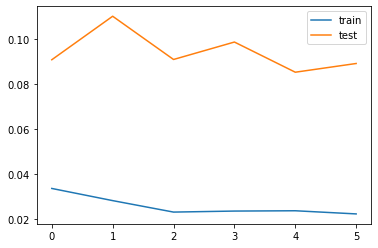

(121, 7)
(121, 7)
(121, 7)
score_train: [201.517] 184.0, 197.5, 203.7, 203.2, 205.1, 204.6, 211.3
(29, 1, 35)
score_test: [447.117] 459.8, 315.9, 209.5, 337.6, 601.0, 503.6, 561.8

RMSE test:  447.11722084100853 


Units CNN1:  255 ,Sequence size:  7
(121, 1, 35)
Epoch 1/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0356 - val_loss: 0.0831
Epoch 2/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0267 - val_loss: 0.0945
Epoch 3/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0248 - val_loss: 0.0861
Epoch 4/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0230 - val_loss: 0.1000
Epoch 5/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0239 - val_loss: 0.0719
Epoch 6/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0209 - val_loss: 0.0726
Model: "sequential_52"
_________________________________________________________________
Layer (type)                 Output Shape            

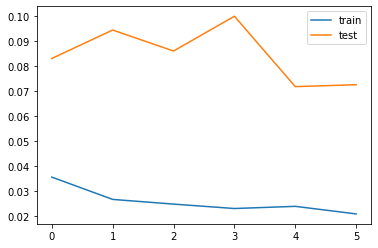

(121, 7)
(121, 7)
(121, 7)
score_train: [202.410] 184.5, 196.3, 201.2, 204.7, 206.3, 207.3, 215.2
(29, 1, 35)
score_test: [403.946] 385.6, 276.0, 177.6, 288.1, 521.8, 486.7, 541.9

RMSE test:  403.94608959931185 


Units CNN1:  255 ,Sequence size:  7
(121, 1, 35)
Epoch 1/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0342 - val_loss: 0.0938
Epoch 2/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0258 - val_loss: 0.1007
Epoch 3/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0239 - val_loss: 0.0888
Epoch 4/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0225 - val_loss: 0.0851
Epoch 5/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0220 - val_loss: 0.0840
Epoch 6/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0209 - val_loss: 0.0752
Model: "sequential_53"
_________________________________________________________________
Layer (type)                 Output Shape            

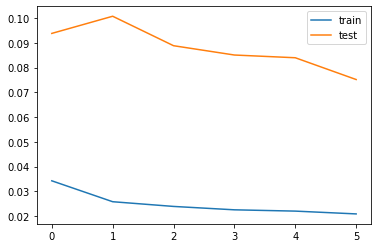

(121, 7)
(121, 7)
(121, 7)
score_train: [210.084] 187.7, 198.4, 218.9, 224.9, 213.0, 207.0, 218.3
(29, 1, 35)
score_test: [410.950] 364.3, 286.6, 243.3, 358.6, 547.4, 452.0, 524.8

RMSE test:  410.95025575823786 


Units CNN1:  255 ,Sequence size:  7
(121, 1, 35)
Epoch 1/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0327 - val_loss: 0.1096
Epoch 2/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0252 - val_loss: 0.0923
Epoch 3/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0249 - val_loss: 0.1047
Epoch 4/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0226 - val_loss: 0.0816
Epoch 5/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0220 - val_loss: 0.0837
Epoch 6/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0229 - val_loss: 0.0772
Model: "sequential_54"
_________________________________________________________________
Layer (type)                 Output Shape            

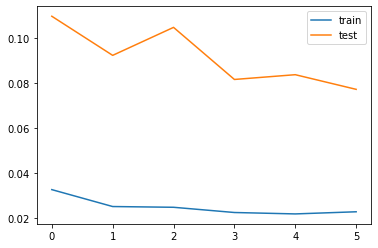

(121, 7)
(121, 7)
(121, 7)
score_train: [207.488] 181.4, 202.7, 231.7, 205.2, 208.0, 206.9, 213.4
(29, 1, 35)
score_test: [416.534] 359.4, 335.0, 286.3, 200.6, 565.0, 528.2, 502.7

RMSE test:  416.53360946839445 


Units CNN1:  255 ,Sequence size:  7
(121, 1, 35)
Epoch 1/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0321 - val_loss: 0.0768
Epoch 2/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0273 - val_loss: 0.0923
Epoch 3/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0236 - val_loss: 0.0798
Epoch 4/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0238 - val_loss: 0.0934
Epoch 5/6
121/121 [==============================] - 0s 3ms/step - loss: 0.0220 - val_loss: 0.0696
Epoch 6/6
121/121 [==============================] - 0s 3ms/step - loss: 0.0229 - val_loss: 0.0908
Model: "sequential_55"
_________________________________________________________________
Layer (type)                 Output Shape            

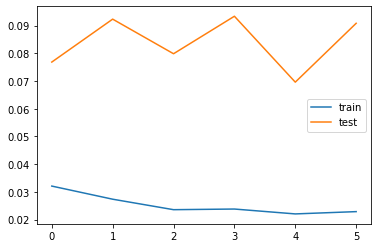

(121, 7)
(121, 7)
(121, 7)
score_train: [207.399] 190.1, 212.2, 204.7, 210.5, 209.7, 207.3, 216.3
(29, 1, 35)
score_test: [451.762] 409.7, 274.6, 248.9, 344.4, 571.9, 560.3, 603.2

RMSE test:  451.76218473047555 


Units CNN1:  251 ,Sequence size:  7
(121, 1, 35)
Epoch 1/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0326 - val_loss: 0.0976
Epoch 2/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0269 - val_loss: 0.1212
Epoch 3/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0253 - val_loss: 0.0728
Epoch 4/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0230 - val_loss: 0.0858
Epoch 5/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0227 - val_loss: 0.0841
Epoch 6/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0218 - val_loss: 0.0593
Model: "sequential_56"
_________________________________________________________________
Layer (type)                 Output Shape            

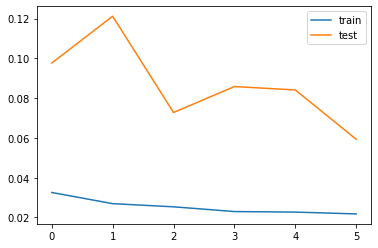

(121, 7)
(121, 7)
(121, 7)
score_train: [206.811] 179.5, 201.0, 203.6, 208.6, 232.1, 205.7, 213.7
(29, 1, 35)
score_test: [365.129] 385.7, 325.9, 177.9, 185.3, 413.9, 454.2, 484.4

RMSE test:  365.12936241586857 


Units CNN1:  255 ,Sequence size:  7
(121, 1, 35)
Epoch 1/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0314 - val_loss: 0.0975
Epoch 2/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0256 - val_loss: 0.0841
Epoch 3/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0255 - val_loss: 0.0758
Epoch 4/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0224 - val_loss: 0.0662
Epoch 5/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0214 - val_loss: 0.0691
Epoch 6/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0225 - val_loss: 0.0756
Model: "sequential_57"
_________________________________________________________________
Layer (type)                 Output Shape            

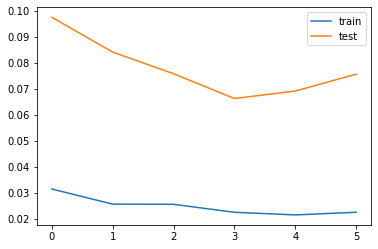

(121, 7)
(121, 7)
(121, 7)
score_train: [205.244] 186.0, 206.6, 211.4, 208.5, 202.4, 205.9, 214.6
(29, 1, 35)
score_test: [412.101] 377.5, 302.6, 188.6, 246.6, 539.0, 534.7, 530.9

RMSE test:  412.1006291420245 


Units CNN1:  255 ,Sequence size:  7
(121, 1, 35)
Epoch 1/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0365 - val_loss: 0.0861
Epoch 2/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0260 - val_loss: 0.0878
Epoch 3/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0246 - val_loss: 0.0749
Epoch 4/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0230 - val_loss: 0.0851
Epoch 5/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0216 - val_loss: 0.0749
Epoch 6/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0218 - val_loss: 0.0824
Model: "sequential_58"
_________________________________________________________________
Layer (type)                 Output Shape             

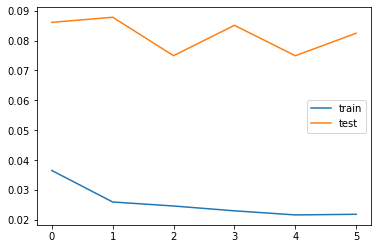

(121, 7)
(121, 7)
(121, 7)
score_train: [203.443] 181.2, 196.8, 208.8, 204.1, 210.4, 203.0, 217.7
(29, 1, 35)
score_test: [430.419] 333.9, 262.5, 182.7, 248.5, 589.6, 555.1, 604.6

RMSE test:  430.41924309233224 

6  	9     	342.369	3.64999	341.152	353.319

Units CNN1:  255 ,Sequence size:  7
(121, 1, 35)
Epoch 1/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0334 - val_loss: 0.1079
Epoch 2/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0263 - val_loss: 0.0985
Epoch 3/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0238 - val_loss: 0.0663
Epoch 4/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0234 - val_loss: 0.0930
Epoch 5/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0228 - val_loss: 0.0724
Epoch 6/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0216 - val_loss: 0.1109
Model: "sequential_59"
_________________________________________________________________
Layer (typ

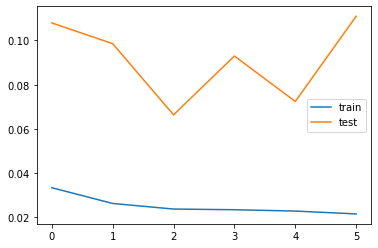

(121, 7)
(121, 7)
(121, 7)
score_train: [225.421] 187.3, 216.8, 235.6, 233.0, 260.0, 223.1, 215.4
(29, 1, 35)
score_test: [499.281] 399.9, 383.9, 286.2, 368.8, 706.7, 622.6, 576.8

RMSE test:  499.2810639357566 


Units CNN1:  255 ,Sequence size:  7
(121, 1, 35)
Epoch 1/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0324 - val_loss: 0.1040
Epoch 2/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0255 - val_loss: 0.0977
Epoch 3/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0242 - val_loss: 0.0815
Epoch 4/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0224 - val_loss: 0.0969
Epoch 5/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0223 - val_loss: 0.0647
Epoch 6/6
121/121 [==============================] - 0s 3ms/step - loss: 0.0216 - val_loss: 0.0700
Model: "sequential_60"
_________________________________________________________________
Layer (type)                 Output Shape             

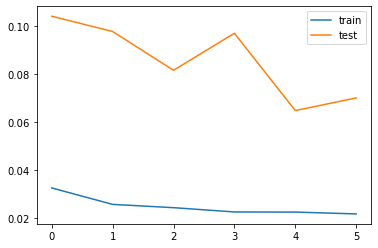

(121, 7)
(121, 7)
(121, 7)
score_train: [202.549] 179.1, 203.2, 200.7, 210.1, 196.2, 217.6, 208.7
(29, 1, 35)
score_test: [396.493] 392.6, 287.6, 210.7, 374.0, 495.3, 427.1, 501.6

RMSE test:  396.49305903413455 


Units CNN1:  255 ,Sequence size:  7
(121, 1, 35)
Epoch 1/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0366 - val_loss: 0.1118
Epoch 2/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0256 - val_loss: 0.1053
Epoch 3/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0258 - val_loss: 0.0607
Epoch 4/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0243 - val_loss: 0.0616
Epoch 5/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0213 - val_loss: 0.0536
Epoch 6/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0218 - val_loss: 0.0750
Model: "sequential_61"
_________________________________________________________________
Layer (type)                 Output Shape            

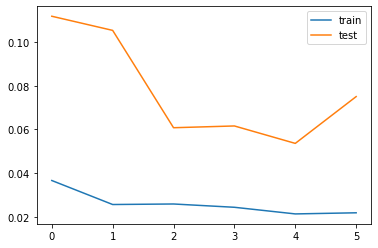

(121, 7)
(121, 7)
(121, 7)
score_train: [206.127] 187.5, 199.2, 200.9, 216.7, 208.2, 205.6, 222.9
(29, 1, 35)
score_test: [410.510] 388.2, 291.5, 158.4, 276.7, 550.4, 499.3, 538.6

RMSE test:  410.51033031805156 


Units CNN1:  239 ,Sequence size:  7
(121, 1, 35)
Epoch 1/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0319 - val_loss: 0.1032
Epoch 2/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0288 - val_loss: 0.0916
Epoch 3/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0256 - val_loss: 0.0946
Epoch 4/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0234 - val_loss: 0.0901
Epoch 5/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0226 - val_loss: 0.0663
Epoch 6/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0215 - val_loss: 0.0595
Model: "sequential_62"
_________________________________________________________________
Layer (type)                 Output Shape            

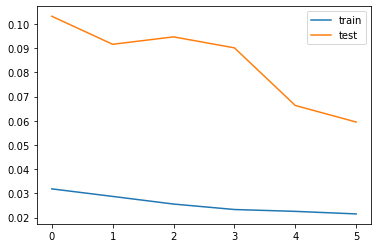

(121, 7)
(121, 7)
(121, 7)
score_train: [207.004] 197.0, 222.5, 205.6, 204.9, 201.9, 205.7, 210.6
(29, 1, 35)
score_test: [365.579] 363.3, 205.5, 191.3, 270.5, 500.4, 412.9, 480.3

RMSE test:  365.5785849020208 


Units CNN1:  251 ,Sequence size:  7
(121, 1, 35)
Epoch 1/6
121/121 [==============================] - 0s 4ms/step - loss: 0.0311 - val_loss: 0.0801
Epoch 2/6
121/121 [==============================] - 0s 3ms/step - loss: 0.0278 - val_loss: 0.0836
Epoch 3/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0249 - val_loss: 0.0905
Epoch 4/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0229 - val_loss: 0.0546
Epoch 5/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0241 - val_loss: 0.0688
Epoch 6/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0225 - val_loss: 0.0734
Model: "sequential_63"
_________________________________________________________________
Layer (type)                 Output Shape             

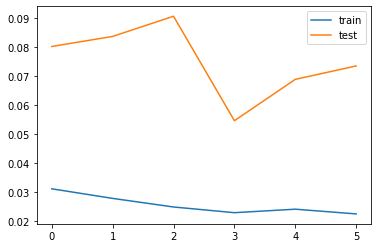

(121, 7)
(121, 7)
(121, 7)
score_train: [206.394] 192.2, 199.7, 204.0, 209.9, 203.3, 204.1, 229.5
(29, 1, 35)
score_test: [406.179] 350.1, 267.0, 179.3, 304.4, 531.9, 492.6, 557.3

RMSE test:  406.1790309806805 


Units CNN1:  127 ,Sequence size:  7
(121, 1, 35)
Epoch 1/6
121/121 [==============================] - 0s 3ms/step - loss: 0.0363 - val_loss: 0.1007
Epoch 2/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0275 - val_loss: 0.0888
Epoch 3/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0246 - val_loss: 0.0905
Epoch 4/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0227 - val_loss: 0.0673
Epoch 5/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0227 - val_loss: 0.0695
Epoch 6/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0221 - val_loss: 0.0748
Model: "sequential_64"
_________________________________________________________________
Layer (type)                 Output Shape             

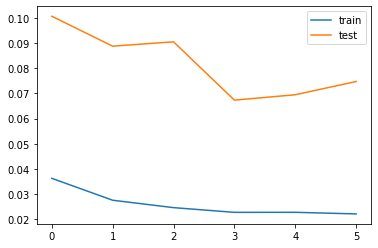

(121, 7)
(121, 7)
(121, 7)
score_train: [205.620] 181.2, 201.7, 206.0, 209.9, 218.0, 205.9, 214.5
(29, 1, 35)
score_test: [409.856] 304.6, 250.4, 157.8, 366.5, 620.5, 478.2, 497.5

RMSE test:  409.855818202161 


Units CNN1:  255 ,Sequence size:  7
(121, 1, 35)
Epoch 1/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0313 - val_loss: 0.0829
Epoch 2/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0270 - val_loss: 0.0936
Epoch 3/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0234 - val_loss: 0.0641
Epoch 4/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0229 - val_loss: 0.0903
Epoch 5/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0214 - val_loss: 0.0505
Epoch 6/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0215 - val_loss: 0.0665
Model: "sequential_65"
_________________________________________________________________
Layer (type)                 Output Shape              

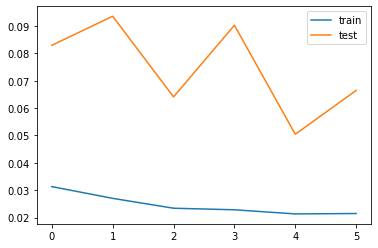

(121, 7)
(121, 7)
(121, 7)
score_train: [204.805] 189.4, 203.2, 213.6, 204.0, 202.8, 206.6, 213.1
(29, 1, 35)
score_test: [386.448] 299.4, 278.1, 192.0, 263.7, 507.8, 472.6, 539.3

RMSE test:  386.44773598936837 


Units CNN1:  255 ,Sequence size:  7
(121, 1, 35)
Epoch 1/6
121/121 [==============================] - 0s 4ms/step - loss: 0.0314 - val_loss: 0.0890
Epoch 2/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0263 - val_loss: 0.0723
Epoch 3/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0232 - val_loss: 0.0838
Epoch 4/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0252 - val_loss: 0.1064
Epoch 5/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0229 - val_loss: 0.0891
Epoch 6/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0212 - val_loss: 0.0765
Model: "sequential_66"
_________________________________________________________________
Layer (type)                 Output Shape            

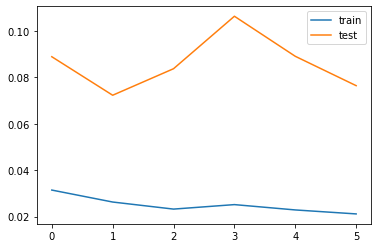

(121, 7)
(121, 7)
(121, 7)
score_train: [202.163] 180.5, 195.0, 215.9, 210.5, 202.6, 198.1, 210.4
(29, 1, 35)
score_test: [414.536] 369.2, 302.5, 166.9, 172.7, 535.4, 544.6, 578.0

RMSE test:  414.53609317048887 


Units CNN1:  255 ,Sequence size:  7
(121, 1, 35)
Epoch 1/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0315 - val_loss: 0.0832
Epoch 2/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0277 - val_loss: 0.0861
Epoch 3/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0245 - val_loss: 0.0864
Epoch 4/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0232 - val_loss: 0.0695
Epoch 5/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0221 - val_loss: 0.0663
Epoch 6/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0223 - val_loss: 0.0701
Model: "sequential_67"
_________________________________________________________________
Layer (type)                 Output Shape            

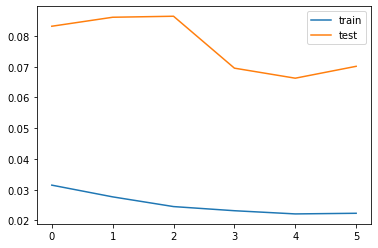

(121, 7)
(121, 7)
(121, 7)
score_train: [201.699] 191.1, 196.9, 205.2, 205.6, 200.8, 201.3, 210.4
(29, 1, 35)
score_test: [396.995] 367.1, 253.9, 155.0, 254.5, 544.9, 507.8, 510.3

RMSE test:  396.9953604629419 

7  	9     	341.152	5.68434e-14	341.152	341.152

Units CNN1:  255 ,Sequence size:  7
(121, 1, 35)
Epoch 1/6
121/121 [==============================] - 1s 5ms/step - loss: 0.0295 - val_loss: 0.0819
Epoch 2/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0260 - val_loss: 0.0879
Epoch 3/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0238 - val_loss: 0.0730
Epoch 4/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0223 - val_loss: 0.0876
Epoch 5/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0220 - val_loss: 0.0834
Epoch 6/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0204 - val_loss: 0.0700
Model: "sequential_68"
_________________________________________________________________
Layer (

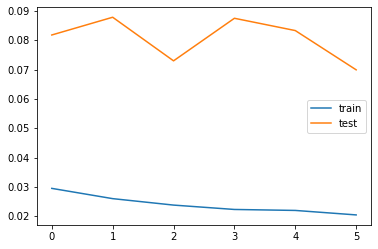

(121, 7)
(121, 7)
(121, 7)
score_train: [207.404] 181.6, 196.7, 212.2, 218.1, 225.1, 204.4, 210.7
(29, 1, 35)
score_test: [396.526] 329.7, 248.0, 179.1, 321.5, 556.9, 446.2, 534.5

RMSE test:  396.5256200489221 


Units CNN1:  255 ,Sequence size:  7
(121, 1, 35)
Epoch 1/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0317 - val_loss: 0.0692
Epoch 2/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0261 - val_loss: 0.0853
Epoch 3/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0237 - val_loss: 0.0738
Epoch 4/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0244 - val_loss: 0.0734
Epoch 5/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0212 - val_loss: 0.0698
Epoch 6/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0211 - val_loss: 0.0764
Model: "sequential_69"
_________________________________________________________________
Layer (type)                 Output Shape             

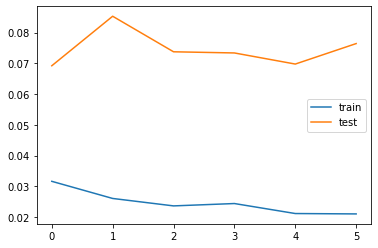

(121, 7)
(121, 7)
(121, 7)
score_train: [215.006] 213.1, 220.7, 209.2, 216.1, 211.2, 208.0, 226.1
(29, 1, 35)
score_test: [414.393] 243.8, 243.6, 161.4, 387.5, 670.4, 497.3, 458.6

RMSE test:  414.39337424514946 


Units CNN1:  255 ,Sequence size:  7
(121, 1, 35)
Epoch 1/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0322 - val_loss: 0.1015
Epoch 2/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0269 - val_loss: 0.1058
Epoch 3/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0229 - val_loss: 0.0707
Epoch 4/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0225 - val_loss: 0.0730
Epoch 5/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0225 - val_loss: 0.0842
Epoch 6/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0224 - val_loss: 0.0795
Model: "sequential_70"
_________________________________________________________________
Layer (type)                 Output Shape            

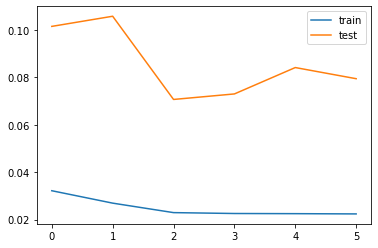

(121, 7)
(121, 7)
(121, 7)
score_train: [215.553] 184.1, 214.5, 249.5, 215.9, 205.9, 216.9, 216.9
(29, 1, 35)
score_test: [422.543] 380.0, 309.5, 237.0, 339.9, 533.7, 537.6, 513.8

RMSE test:  422.542941115478 


Units CNN1:  255 ,Sequence size:  7
(121, 1, 35)
Epoch 1/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0364 - val_loss: 0.1001
Epoch 2/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0252 - val_loss: 0.0904
Epoch 3/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0254 - val_loss: 0.1038
Epoch 4/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0230 - val_loss: 0.1031
Epoch 5/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0223 - val_loss: 0.0996
Epoch 6/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0232 - val_loss: 0.0830
Model: "sequential_71"
_________________________________________________________________
Layer (type)                 Output Shape              

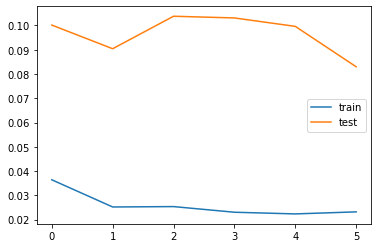

(121, 7)
(121, 7)
(121, 7)
score_train: [204.683] 185.3, 201.3, 203.1, 206.8, 206.6, 209.9, 218.2
(29, 1, 35)
score_test: [431.759] 460.2, 359.6, 179.4, 274.3, 519.7, 530.9, 551.8

RMSE test:  431.7587836047999 


Units CNN1:  247 ,Sequence size:  7
(121, 1, 35)
Epoch 1/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0343 - val_loss: 0.1176
Epoch 2/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0277 - val_loss: 0.0940
Epoch 3/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0251 - val_loss: 0.0818
Epoch 4/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0242 - val_loss: 0.0945
Epoch 5/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0225 - val_loss: 0.0836
Epoch 6/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0211 - val_loss: 0.0835
Model: "sequential_72"
_________________________________________________________________
Layer (type)                 Output Shape             

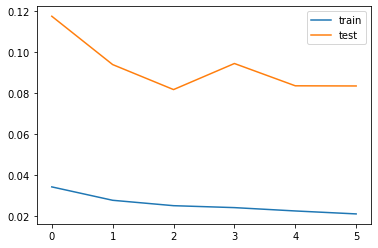

(121, 7)
(121, 7)
(121, 7)
score_train: [202.541] 183.7, 200.4, 203.9, 202.3, 201.7, 212.4, 212.1
(29, 1, 35)
score_test: [433.268] 408.4, 292.9, 198.1, 303.5, 579.6, 510.5, 577.5

RMSE test:  433.26796154591796 


Units CNN1:  223 ,Sequence size:  7
(121, 1, 35)
Epoch 1/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0317 - val_loss: 0.0856
Epoch 2/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0261 - val_loss: 0.0741
Epoch 3/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0233 - val_loss: 0.0725
Epoch 4/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0223 - val_loss: 0.0658
Epoch 5/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0227 - val_loss: 0.0851
Epoch 6/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0209 - val_loss: 0.0624
Model: "sequential_73"
_________________________________________________________________
Layer (type)                 Output Shape            

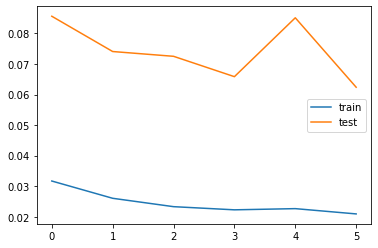

(121, 7)
(121, 7)
(121, 7)
score_train: [206.148] 200.0, 194.6, 199.0, 200.5, 198.6, 204.3, 242.0
(29, 1, 35)
score_test: [374.394] 288.9, 300.8, 174.5, 331.4, 475.8, 515.3, 418.3

RMSE test:  374.3941879565702 


Units CNN1:  255 ,Sequence size:  7
(121, 1, 35)
Epoch 1/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0319 - val_loss: 0.0939
Epoch 2/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0255 - val_loss: 0.0910
Epoch 3/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0246 - val_loss: 0.0740
Epoch 4/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0233 - val_loss: 0.0734
Epoch 5/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0217 - val_loss: 0.0677
Epoch 6/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0206 - val_loss: 0.0597
Model: "sequential_74"
_________________________________________________________________
Layer (type)                 Output Shape             

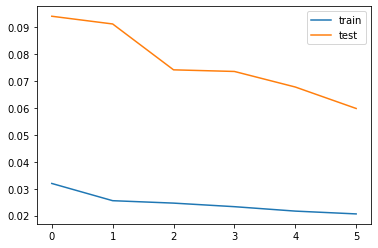

(121, 7)
(121, 7)
(121, 7)
score_train: [207.440] 186.6, 213.6, 200.3, 232.4, 201.4, 205.8, 209.1
(29, 1, 35)
score_test: [366.328] 357.0, 225.9, 220.8, 145.4, 442.3, 484.3, 510.8

RMSE test:  366.3280312587066 


Units CNN1:  255 ,Sequence size:  7
(121, 1, 35)
Epoch 1/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0308 - val_loss: 0.0926
Epoch 2/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0265 - val_loss: 0.0843
Epoch 3/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0239 - val_loss: 0.0801
Epoch 4/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0239 - val_loss: 0.0781
Epoch 5/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0235 - val_loss: 0.0643
Epoch 6/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0210 - val_loss: 0.0860
Model: "sequential_75"
_________________________________________________________________
Layer (type)                 Output Shape             

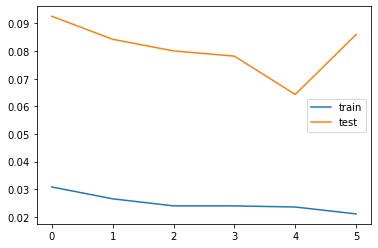

(121, 7)
(121, 7)
(121, 7)
score_train: [211.037] 184.8, 211.9, 201.5, 202.7, 239.5, 207.7, 224.8
(29, 1, 35)
score_test: [439.608] 317.1, 270.5, 177.4, 285.0, 621.3, 554.9, 610.4

RMSE test:  439.6084551481746 


Units CNN1:  239 ,Sequence size:  7
(121, 1, 35)
Epoch 1/6
121/121 [==============================] - 0s 3ms/step - loss: 0.0312 - val_loss: 0.0894
Epoch 2/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0269 - val_loss: 0.0855
Epoch 3/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0228 - val_loss: 0.0696
Epoch 4/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0237 - val_loss: 0.0742
Epoch 5/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0222 - val_loss: 0.1033
Epoch 6/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0220 - val_loss: 0.0824
Model: "sequential_76"
_________________________________________________________________
Layer (type)                 Output Shape             

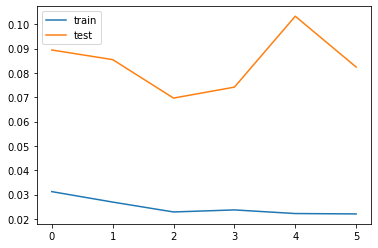

(121, 7)
(121, 7)
(121, 7)
score_train: [211.423] 209.3, 206.7, 208.4, 214.4, 203.4, 221.0, 216.2
(29, 1, 35)
score_test: [430.291] 403.3, 347.7, 208.2, 330.0, 543.3, 498.8, 562.4

RMSE test:  430.29095118286097 


Units CNN1:  127 ,Sequence size:  7
(121, 1, 35)
Epoch 1/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0370 - val_loss: 0.1285
Epoch 2/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0279 - val_loss: 0.1071
Epoch 3/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0244 - val_loss: 0.0570
Epoch 4/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0240 - val_loss: 0.0908
Epoch 5/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0235 - val_loss: 0.0574
Epoch 6/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0213 - val_loss: 0.0797
Model: "sequential_77"
_________________________________________________________________
Layer (type)                 Output Shape            

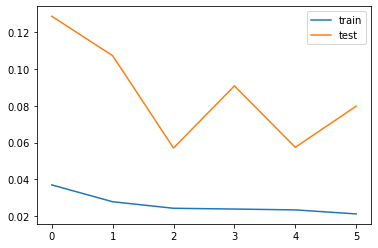

(121, 7)
(121, 7)
(121, 7)
score_train: [208.366] 181.7, 211.2, 206.8, 225.9, 202.6, 211.9, 215.8
(29, 1, 35)
score_test: [423.288] 410.9, 383.9, 175.1, 302.0, 501.8, 528.9, 533.6

RMSE test:  423.2879177651059 

8  	10    	341.152	5.68434e-14	341.152	341.152

Units CNN1:  255 ,Sequence size:  7
(121, 1, 35)
Epoch 1/6
121/121 [==============================] - 1s 5ms/step - loss: 0.0307 - val_loss: 0.0638
Epoch 2/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0268 - val_loss: 0.1014
Epoch 3/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0234 - val_loss: 0.0836
Epoch 4/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0240 - val_loss: 0.0788
Epoch 5/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0215 - val_loss: 0.0881
Epoch 6/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0220 - val_loss: 0.0855
Model: "sequential_78"
_________________________________________________________________
Layer (

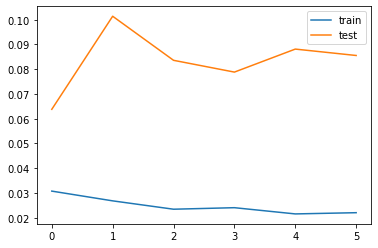

(121, 7)
(121, 7)
(121, 7)
score_train: [205.076] 194.9, 200.3, 204.6, 204.6, 202.5, 207.3, 220.5
(29, 1, 35)
score_test: [438.423] 368.7, 365.7, 170.5, 272.9, 586.0, 566.5, 555.0

RMSE test:  438.42269639317857 


Units CNN1:  255 ,Sequence size:  7
(121, 1, 35)
Epoch 1/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0332 - val_loss: 0.0950
Epoch 2/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0272 - val_loss: 0.0776
Epoch 3/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0253 - val_loss: 0.0838
Epoch 4/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0232 - val_loss: 0.0584
Epoch 5/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0237 - val_loss: 0.0711
Epoch 6/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0223 - val_loss: 0.0701
Model: "sequential_79"
_________________________________________________________________
Layer (type)                 Output Shape            

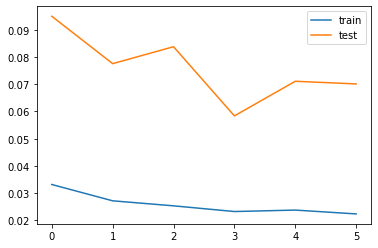

(121, 7)
(121, 7)
(121, 7)
score_train: [204.503] 188.7, 206.0, 202.2, 210.5, 199.5, 208.7, 214.9
(29, 1, 35)
score_test: [396.983] 351.2, 300.5, 212.7, 236.0, 482.3, 485.6, 565.8

RMSE test:  396.9832324992348 


Units CNN1:  255 ,Sequence size:  7
(121, 1, 35)
Epoch 1/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0340 - val_loss: 0.1086
Epoch 2/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0262 - val_loss: 0.1005
Epoch 3/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0258 - val_loss: 0.0828
Epoch 4/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0242 - val_loss: 0.0770
Epoch 5/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0212 - val_loss: 0.0776
Epoch 6/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0210 - val_loss: 0.0691
Model: "sequential_80"
_________________________________________________________________
Layer (type)                 Output Shape             

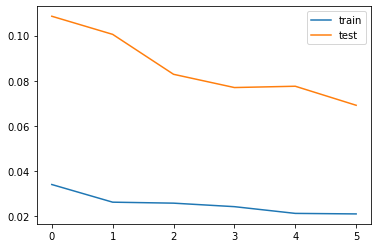

(121, 7)
(121, 7)
(121, 7)
score_train: [207.950] 184.6, 195.9, 211.1, 249.0, 202.7, 201.2, 205.1
(29, 1, 35)
score_test: [394.106] 361.0, 316.6, 186.0, 171.6, 537.6, 446.8, 551.4

RMSE test:  394.10632308641306 


Units CNN1:  255 ,Sequence size:  7
(121, 1, 35)
Epoch 1/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0329 - val_loss: 0.0857
Epoch 2/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0265 - val_loss: 0.0957
Epoch 3/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0234 - val_loss: 0.0847
Epoch 4/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0239 - val_loss: 0.0935
Epoch 5/6
121/121 [==============================] - 0s 3ms/step - loss: 0.0210 - val_loss: 0.0730
Epoch 6/6
121/121 [==============================] - 0s 3ms/step - loss: 0.0212 - val_loss: 0.0752
Model: "sequential_81"
_________________________________________________________________
Layer (type)                 Output Shape            

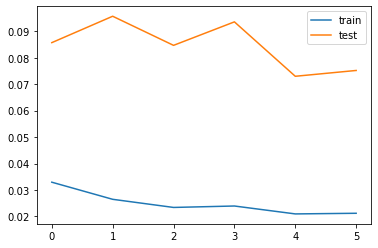

(121, 7)
(121, 7)
(121, 7)
score_train: [204.216] 186.7, 202.6, 201.8, 205.3, 209.6, 206.7, 215.5
(29, 1, 35)
score_test: [410.992] 365.3, 316.0, 195.3, 314.1, 443.5, 491.9, 611.2

RMSE test:  410.9917012225051 


Units CNN1:  255 ,Sequence size:  7
(121, 1, 35)
Epoch 1/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0320 - val_loss: 0.0971
Epoch 2/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0260 - val_loss: 0.0743
Epoch 3/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0253 - val_loss: 0.1163
Epoch 4/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0231 - val_loss: 0.0861
Epoch 5/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0220 - val_loss: 0.0767
Epoch 6/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0214 - val_loss: 0.0821
Model: "sequential_82"
_________________________________________________________________
Layer (type)                 Output Shape             

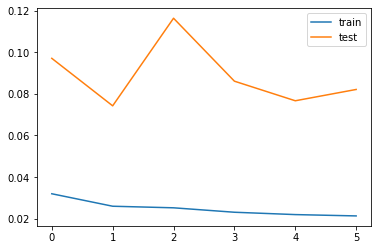

(121, 7)
(121, 7)
(121, 7)
score_train: [204.471] 189.3, 197.3, 214.0, 205.3, 201.7, 207.3, 215.1
(29, 1, 35)
score_test: [429.558] 375.6, 314.4, 228.1, 271.7, 529.7, 580.7, 555.1

RMSE test:  429.55788371528405 


Units CNN1:  255 ,Sequence size:  7
(121, 1, 35)
Epoch 1/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0296 - val_loss: 0.1045
Epoch 2/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0240 - val_loss: 0.0707
Epoch 3/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0239 - val_loss: 0.1057
Epoch 4/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0235 - val_loss: 0.0831
Epoch 5/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0219 - val_loss: 0.0764
Epoch 6/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0211 - val_loss: 0.0793
Model: "sequential_83"
_________________________________________________________________
Layer (type)                 Output Shape            

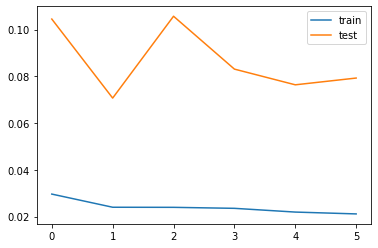

(121, 7)
(121, 7)
(121, 7)
score_train: [203.850] 186.0, 214.3, 207.2, 200.1, 198.3, 204.8, 214.7
(29, 1, 35)
score_test: [422.041] 382.1, 361.9, 245.6, 286.9, 517.8, 480.0, 573.4

RMSE test:  422.04098511877214 


Units CNN1:  255 ,Sequence size:  7
(121, 1, 35)
Epoch 1/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0356 - val_loss: 0.1098
Epoch 2/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0284 - val_loss: 0.0901
Epoch 3/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0252 - val_loss: 0.0890
Epoch 4/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0224 - val_loss: 0.0918
Epoch 5/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0220 - val_loss: 0.0785
Epoch 6/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0235 - val_loss: 0.0892
Model: "sequential_84"
_________________________________________________________________
Layer (type)                 Output Shape            

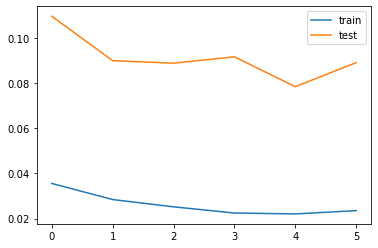

(121, 7)
(121, 7)
(121, 7)
score_train: [216.229] 230.9, 198.8, 207.0, 206.5, 219.8, 234.8, 213.4
(29, 1, 35)
score_test: [447.678] 416.0, 320.2, 200.7, 409.7, 439.2, 603.0, 602.2

RMSE test:  447.6780131211582 


Units CNN1:  255 ,Sequence size:  7
(121, 1, 35)
Epoch 1/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0301 - val_loss: 0.0695
Epoch 2/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0265 - val_loss: 0.0719
Epoch 3/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0255 - val_loss: 0.0803
Epoch 4/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0223 - val_loss: 0.0742
Epoch 5/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0232 - val_loss: 0.0744
Epoch 6/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0217 - val_loss: 0.0730
Model: "sequential_85"
_________________________________________________________________
Layer (type)                 Output Shape             

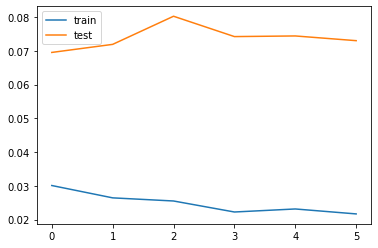

(121, 7)
(121, 7)
(121, 7)
score_train: [206.929] 191.3, 203.8, 210.3, 205.7, 215.4, 213.0, 208.2
(29, 1, 35)
score_test: [405.075] 342.7, 332.9, 244.7, 222.8, 566.7, 467.8, 520.4

RMSE test:  405.074794582035 


Units CNN1:  255 ,Sequence size:  7
(121, 1, 35)
Epoch 1/6
121/121 [==============================] - 0s 3ms/step - loss: 0.0310 - val_loss: 0.0948
Epoch 2/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0272 - val_loss: 0.0868
Epoch 3/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0246 - val_loss: 0.0879
Epoch 4/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0217 - val_loss: 0.0639
Epoch 5/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0216 - val_loss: 0.0981
Epoch 6/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0220 - val_loss: 0.0612
Model: "sequential_86"
_________________________________________________________________
Layer (type)                 Output Shape              

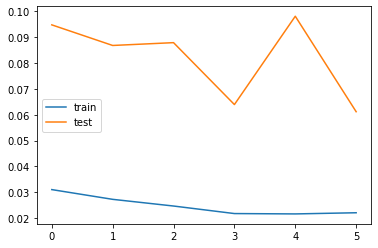

(121, 7)
(121, 7)
(121, 7)
score_train: [207.087] 182.6, 215.9, 214.4, 202.5, 210.3, 205.2, 216.5
(29, 1, 35)
score_test: [370.732] 356.9, 317.8, 165.6, 269.8, 477.3, 433.5, 466.6

RMSE test:  370.73210177461976 


Units CNN1:  255 ,Sequence size:  7
(121, 1, 35)
Epoch 1/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0355 - val_loss: 0.1197
Epoch 2/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0278 - val_loss: 0.0831
Epoch 3/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0265 - val_loss: 0.0721
Epoch 4/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0223 - val_loss: 0.0815
Epoch 5/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0215 - val_loss: 0.0860
Epoch 6/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0217 - val_loss: 0.0758
Model: "sequential_87"
_________________________________________________________________
Layer (type)                 Output Shape            

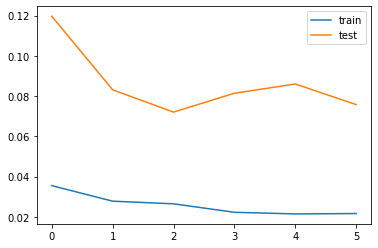

(121, 7)
(121, 7)
(121, 7)
score_train: [203.482] 185.6, 201.3, 203.8, 206.2, 201.8, 207.9, 216.5
(29, 1, 35)
score_test: [412.720] 363.1, 322.2, 182.9, 348.7, 492.5, 473.5, 578.7

RMSE test:  412.71955303599844 

9  	10    	341.152	5.68434e-14	341.152	341.152

Units CNN1:  255 ,Sequence size:  7
(121, 1, 35)
Epoch 1/6
121/121 [==============================] - 1s 5ms/step - loss: 0.0328 - val_loss: 0.0920
Epoch 2/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0252 - val_loss: 0.0796
Epoch 3/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0250 - val_loss: 0.0568
Epoch 4/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0230 - val_loss: 0.0647
Epoch 5/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0221 - val_loss: 0.0681
Epoch 6/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0213 - val_loss: 0.0818
Model: "sequential_88"
_________________________________________________________________
Layer 

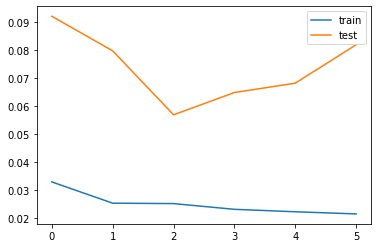

(121, 7)
(121, 7)
(121, 7)
score_train: [205.831] 186.0, 202.4, 220.7, 201.9, 208.9, 205.7, 213.5
(29, 1, 35)
score_test: [428.813] 441.9, 325.4, 271.1, 315.1, 522.4, 502.7, 536.2

RMSE test:  428.81322102705377 


Units CNN1:  255 ,Sequence size:  7
(121, 1, 35)
Epoch 1/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0318 - val_loss: 0.1009
Epoch 2/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0263 - val_loss: 0.1241
Epoch 3/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0236 - val_loss: 0.0946
Epoch 4/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0230 - val_loss: 0.0675
Epoch 5/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0227 - val_loss: 0.0986
Epoch 6/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0220 - val_loss: 0.0704
Model: "sequential_89"
_________________________________________________________________
Layer (type)                 Output Shape            

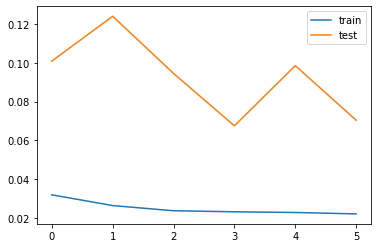

(121, 7)
(121, 7)
(121, 7)
score_train: [205.275] 189.8, 198.5, 207.5, 204.7, 203.0, 213.0, 219.1
(29, 1, 35)
score_test: [397.724] 367.0, 303.0, 225.9, 253.2, 528.6, 469.2, 515.8

RMSE test:  397.72447958698433 


Units CNN1:  255 ,Sequence size:  7
(121, 1, 35)
Epoch 1/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0306 - val_loss: 0.0913
Epoch 2/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0259 - val_loss: 0.0754
Epoch 3/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0235 - val_loss: 0.0800
Epoch 4/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0238 - val_loss: 0.0683
Epoch 5/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0218 - val_loss: 0.0643
Epoch 6/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0209 - val_loss: 0.0857
Model: "sequential_90"
_________________________________________________________________
Layer (type)                 Output Shape            

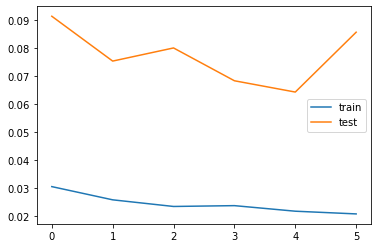

(121, 7)
(121, 7)
(121, 7)
score_train: [203.656] 183.7, 197.8, 205.9, 205.0, 220.4, 201.2, 209.8
(29, 1, 35)
score_test: [438.719] 383.4, 369.7, 186.3, 383.0, 580.1, 508.7, 535.6

RMSE test:  438.71886103732385 


Units CNN1:  255 ,Sequence size:  7
(121, 1, 35)
Epoch 1/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0326 - val_loss: 0.0871
Epoch 2/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0265 - val_loss: 0.0810
Epoch 3/6
121/121 [==============================] - 0s 3ms/step - loss: 0.0238 - val_loss: 0.0797
Epoch 4/6
121/121 [==============================] - 0s 3ms/step - loss: 0.0217 - val_loss: 0.0478
Epoch 5/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0221 - val_loss: 0.0717
Epoch 6/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0217 - val_loss: 0.0665
Model: "sequential_91"
_________________________________________________________________
Layer (type)                 Output Shape            

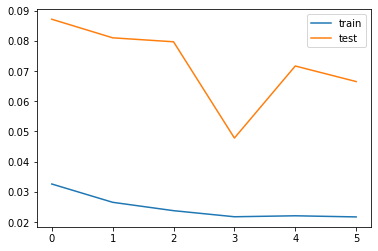

(121, 7)
(121, 7)
(121, 7)
score_train: [201.693] 184.6, 198.9, 203.6, 205.0, 206.3, 200.7, 211.6
(29, 1, 35)
score_test: [386.565] 317.6, 332.0, 170.5, 263.1, 508.3, 473.6, 504.0

RMSE test:  386.56455005712587 


Units CNN1:  255 ,Sequence size:  7
(121, 1, 35)
Epoch 1/6
121/121 [==============================] - 0s 4ms/step - loss: 0.0332 - val_loss: 0.0892
Epoch 2/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0264 - val_loss: 0.0718
Epoch 3/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0244 - val_loss: 0.0915
Epoch 4/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0223 - val_loss: 0.0813
Epoch 5/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0217 - val_loss: 0.0794
Epoch 6/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0213 - val_loss: 0.0680
Model: "sequential_92"
_________________________________________________________________
Layer (type)                 Output Shape            

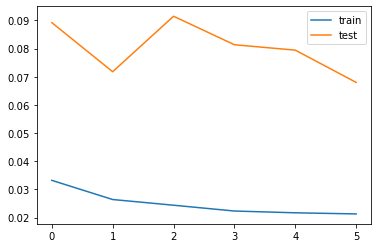

(121, 7)
(121, 7)
(121, 7)
score_train: [209.648] 182.9, 200.0, 209.9, 208.0, 205.8, 237.0, 220.0
(29, 1, 35)
score_test: [390.820] 354.0, 266.3, 236.1, 368.0, 493.6, 448.7, 486.6

RMSE test:  390.82024966101164 


Units CNN1:  255 ,Sequence size:  7
(121, 1, 35)
Epoch 1/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0321 - val_loss: 0.0901
Epoch 2/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0269 - val_loss: 0.0789
Epoch 3/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0242 - val_loss: 0.0957
Epoch 4/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0216 - val_loss: 0.0537
Epoch 5/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0232 - val_loss: 0.0838
Epoch 6/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0216 - val_loss: 0.0912
Model: "sequential_93"
_________________________________________________________________
Layer (type)                 Output Shape            

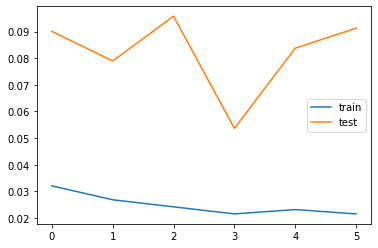

(121, 7)
(121, 7)
(121, 7)
score_train: [205.043] 187.0, 208.5, 217.5, 204.4, 201.2, 204.8, 210.6
(29, 1, 35)
score_test: [452.798] 432.9, 340.5, 314.0, 278.5, 578.8, 567.1, 546.9

RMSE test:  452.797644679476 


Units CNN1:  255 ,Sequence size:  7
(121, 1, 35)
Epoch 1/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0317 - val_loss: 0.1031
Epoch 2/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0259 - val_loss: 0.1016
Epoch 3/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0264 - val_loss: 0.0911
Epoch 4/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0222 - val_loss: 0.0735
Epoch 5/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0225 - val_loss: 0.0792
Epoch 6/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0214 - val_loss: 0.0879
Model: "sequential_94"
_________________________________________________________________
Layer (type)                 Output Shape              

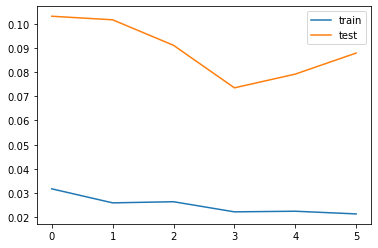

(121, 7)
(121, 7)
(121, 7)
score_train: [215.535] 209.8, 210.6, 215.2, 234.5, 210.4, 216.2, 211.0
(29, 1, 35)
score_test: [444.405] 428.2, 327.9, 208.9, 338.9, 610.0, 530.4, 528.9

RMSE test:  444.4052933361125 


Units CNN1:  255 ,Sequence size:  7
(121, 1, 35)
Epoch 1/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0292 - val_loss: 0.1183
Epoch 2/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0259 - val_loss: 0.0784
Epoch 3/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0240 - val_loss: 0.0933
Epoch 4/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0245 - val_loss: 0.0793
Epoch 5/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0224 - val_loss: 0.0752
Epoch 6/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0210 - val_loss: 0.0707
Model: "sequential_95"
_________________________________________________________________
Layer (type)                 Output Shape             

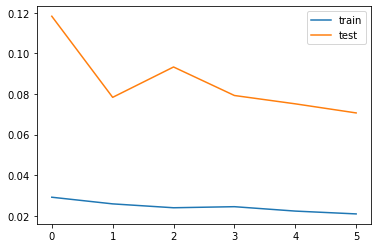

(121, 7)
(121, 7)
(121, 7)
score_train: [206.378] 179.0, 210.9, 204.4, 198.0, 202.6, 225.5, 220.8
(29, 1, 35)
score_test: [398.537] 396.9, 339.2, 176.4, 265.8, 505.1, 525.6, 454.1

RMSE test:  398.5372433453183 


Units CNN1:  255 ,Sequence size:  7
(121, 1, 35)
Epoch 1/6
121/121 [==============================] - 0s 3ms/step - loss: 0.0304 - val_loss: 0.0993
Epoch 2/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0280 - val_loss: 0.0913
Epoch 3/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0238 - val_loss: 0.0675
Epoch 4/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0218 - val_loss: 0.0654
Epoch 5/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0217 - val_loss: 0.0742
Epoch 6/6
121/121 [==============================] - 0s 2ms/step - loss: 0.0220 - val_loss: 0.0640
Model: "sequential_96"
_________________________________________________________________
Layer (type)                 Output Shape             

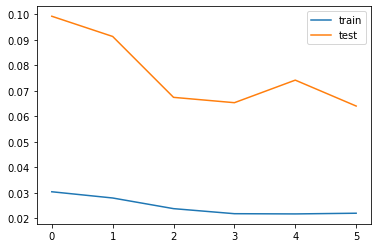

(121, 7)
(121, 7)
(121, 7)
score_train: [210.312] 193.0, 210.1, 208.8, 218.7, 203.6, 207.8, 228.4
(29, 1, 35)
score_test: [379.362] 340.4, 276.0, 177.7, 246.7, 580.0, 439.2, 440.1

RMSE test:  379.36175114792263 

10 	9     	341.152	5.68434e-14	341.152	341.152


In [74]:
population_size = 10
num_generations = 10
# 8 bits for ltsm1 , 8 for lstm 2 , 6 for sequence length , 21 for features selections
# 8 bits for cnn1 ,8 bits for cnn2 , 8 bits for lstm 2 ,8 bits for lstm 2 , 6 bits for sequence length , 21 for features selections
gene_length =8 #58

# As we are trying to minimize the RMSE score, that's why using -1.0. 
# In case, when you want to maximize accuracy for instance, use 1.0
creator.create('FitnessMax', base.Fitness, weights = (-1.0,))
creator.create('Individual', list , fitness = creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register('binary', bernoulli.rvs, 0.9)
toolbox.register('individual', tools.initRepeat, creator.Individual, toolbox.binary, n = gene_length)
toolbox.register('population', tools.initRepeat, list , toolbox.individual)

toolbox.register('mate', tools.cxOrdered)
toolbox.register('mutate', tools.mutShuffleIndexes, indpb = 0.7)
toolbox.register('select', tools.selRoulette)
toolbox.register('evaluate', train_evaluate)
population = toolbox.population(n = population_size)
hof = tools.HallOfFame(1)
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)
#param cxpb: The probability of mating two individuals.
#param mutpb: The probability of mutating an individual.
population , logbook  = algorithms.eaSimple(population, toolbox,halloffame=hof, cxpb = 0.7, mutpb = 0.6,stats=stats, ngen = num_generations, verbose = True)

In [75]:
print('Best score :', best_score)

Best score : 341.1519095791147


In [76]:
model=model_name
model.summary()

Model: "sequential_50"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_50 (Conv1D)           (None, 1, 255)            18105     
_________________________________________________________________
flatten_50 (Flatten)         (None, 255)               0         
_________________________________________________________________
dropout_50 (Dropout)         (None, 255)               0         
_________________________________________________________________
dense_50 (Dense)             (None, 7)                 1792      
Total params: 19,897
Trainable params: 19,897
Non-trainable params: 0
_________________________________________________________________


In [77]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error


# make a prediction
yhat = model.predict(X_test[[0,7,14,21,28]])
yhat.shape 

(5, 7)

In [78]:
yhat = yhat.reshape(-1, yhat.shape[-1])

In [79]:
#yhat

In [80]:
# invert scaling for forecast
y_test_pred = scaler2.inverse_transform(yhat)
#print(inv_yhat)
# invert scaling for actual
Y_test_true =Y_test[[0,7,14,21,28]]
Y_test_true = Y_test_true.reshape(-1, Y_test_true.shape[-1])
y_test_true= scaler2.inverse_transform(Y_test_true)

In [81]:
days

DatetimeIndex(['2020-07-12', '2020-07-13', '2020-07-14', '2020-07-15',
               '2020-07-16', '2020-07-17', '2020-07-18', '2020-07-19',
               '2020-07-20', '2020-07-21', '2020-07-22', '2020-07-23',
               '2020-07-24', '2020-07-25', '2020-07-26', '2020-07-27',
               '2020-07-28', '2020-07-29', '2020-07-30', '2020-07-31',
               '2020-08-01', '2020-08-02', '2020-08-03', '2020-08-04',
               '2020-08-05', '2020-08-06', '2020-08-07', '2020-08-08',
               '2020-08-09', '2020-08-10', '2020-08-11', '2020-08-12',
               '2020-08-13', '2020-08-14', '2020-08-15'],
              dtype='datetime64[ns]', name='timestamp', freq=None)

In [82]:
test_res=pd.DataFrame()
test_res['Prediction']=y_test_pred.flatten()[0:35]
test_res['real']=y_test_true.flatten()[0:35]
test_res.set_index(days,inplace=True)

In [83]:
test_res

,Prediction,real
timestamp,,
2020-07-12,227.721786,214.000000
2020-07-13,166.650635,203.000000
2020-07-14,173.395020,191.000000
2020-07-15,189.373245,161.000000
2020-07-16,188.274429,165.000000
2020-07-17,243.126251,162.000000
2020-07-18,221.406906,302.000000
2020-07-19,244.330627,289.000000
2020-07-20,172.816956,221.000000


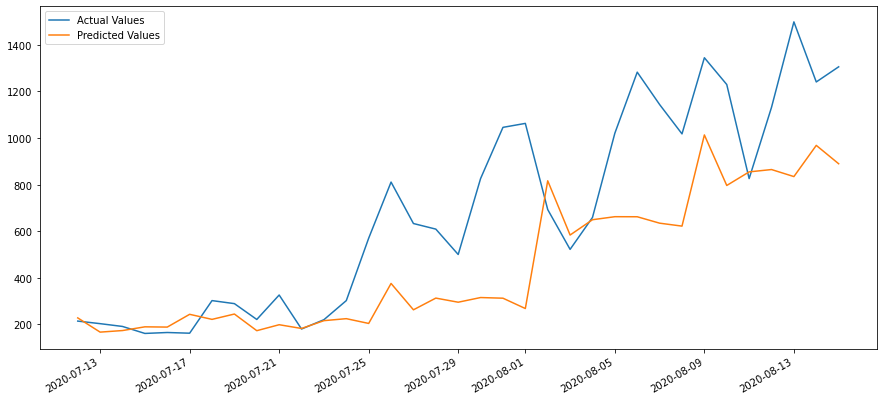

In [84]:

import pandas as pd
import numpy as np; np.random.seed(1)
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15,7))
plt.plot(test_res.index, test_res['real'],  label='Actual Values')
plt.plot(test_res.index, test_res['Prediction'], label='Predicted Values')
# If you don't like the break in the graph, change 90 to 89 in the above line
plt.gcf().autofmt_xdate()
plt.legend()
plt.show()




In [85]:
import numpy as np 
from sklearn import metrics
print('Test Metrics')
print('MSE:', round(metrics.mean_squared_error(test_res['real'], test_res['Prediction']), 2))
print('RMSE:',round( np.sqrt(metrics.mean_squared_error(test_res['real'], test_res['Prediction'])), 2))
print('MAE:', round(metrics.mean_absolute_error(test_res['real'], test_res['Prediction']), 2))
print('R Squared:', round( metrics.r2_score(test_res['real'], test_res['Prediction']), 2))
print('Max Error:',round(  metrics.max_error(test_res['real'], test_res['Prediction']), 2))


Test Metrics
MSE: 116384.62
RMSE: 341.15
MAE: 251.2
R Squared: 0.35
Max Error: 795.02


In [86]:
# make a prediction
y_train_pred = model.predict(X_train)
y_train_pred .shape

(121, 7)

In [87]:
y_train_pred = y_train_pred.reshape(y_train_pred.shape[0], y_train_pred.shape[1])
y_train_pred.shape

(121, 7)

In [88]:

# invert scaling for forecast

y_train_pred = scaler2.inverse_transform(y_train_pred)
Y_train_true = Y_train.reshape((len(Y_train), n_out))

y_train_real = scaler2.inverse_transform(Y_train_true )

In [89]:

# Flatten for final errors
Y_train_pred_bis = y_train_pred.flatten()
Y_train_real_bis = y_train_real.flatten()

In [90]:
y_train_pred[0]

array([46.86382 , 45.04203 , 46.462933, 51.628754, 45.903545, 57.678814,
       75.70745 ], dtype=float32)

In [91]:
#For plot 
#filter_indices = [0,7,14,21,28,35,42,49,56,63,70,77,84,91,98,105,112,119]
filter_indices = [0,7,14,21,28,35,42,49,56,63,70,77,84,91,98,105,112,119]
y_train_pred = y_train_pred [filter_indices ]

In [92]:
# Part of train dataset
y_train_real= y_train_real[filter_indices]
Y_train_pred = y_train_pred.flatten()
Y_train_real = y_train_real.flatten()

In [93]:
mask = (df['date'] >= start_date) & (df['date'] <= end_date) &  (df['location'].isin(['Morocco']))
date_train = df.loc[mask].date.sort_index(axis = 0) 
X_train.shape

(121, 1, 35)

In [94]:
date_train.head(7)

22928   2020-03-02
22929   2020-03-03
22930   2020-03-04
22931   2020-03-05
22932   2020-03-06
22933   2020-03-07
22934   2020-03-08
Name: date, dtype: datetime64[ns]

In [95]:
taille_x = date_train.shape[0] - nb_seq
taille_x 

127

In [96]:
date_train = date_train.values.flatten()

In [97]:
prediction_train = pd.DataFrame(columns=['date_to_prediction','true_value','predict'])

In [98]:
Y_train_pred.shape

(126,)

In [99]:
Y_train_real.shape

(126,)

In [100]:
date_train.shape

(134,)

In [101]:
date_train[nb_seq:].shape

(127,)

In [102]:
suite_size = Y_train_real.shape[0]- date_train[nb_seq:].shape[0]
suite_size 

-1

In [103]:
Y_train_real[:-suite_size].shape

(1,)

In [104]:
date_train[nb_seq:].shape

(127,)

In [105]:
Y_train_pred[:-suite_size].shape

(1,)

In [106]:
Y_train_real[:-suite_size].shape

(1,)

In [107]:
date_trainX = date_train[nb_seq:]

In [108]:
date_trainX[0:Y_train_pred.shape[0]].shape

(126,)

In [109]:
prediction_train['date_to_prediction'] = date_trainX[0:Y_train_pred.shape[0]]
prediction_train['predict'] = Y_train_pred
prediction_train['true_value'] = Y_train_real


In [110]:
prediction_train['date_to_prediction'] = pd.to_datetime(prediction_train['date_to_prediction'], infer_datetime_format=True)

In [111]:
prediction_train.set_index('date_to_prediction',inplace=True)

In [112]:
prediction_train.head(20)

,true_value,predict
date_to_prediction,,
2020-03-09,16.318817,46.863819
2020-03-10,16.318817,45.042030
2020-03-11,16.318817,46.462933
2020-03-12,6.993779,51.628754
2020-03-13,2.331260,45.903545
2020-03-14,2.331260,57.678814
2020-03-15,25.643856,75.707451
2020-03-16,23.312597,57.138386
2020-03-17,20.981337,49.888596


In [113]:
prediction_train.tail(10)

,true_value,predict
date_to_prediction,,
2020-07-03,776.309448,633.517334
2020-07-04,743.671875,757.307068
2020-07-05,1244.892700,744.803406
2020-07-06,916.185059,935.450806
2020-07-07,265.763611,645.388611
2020-07-08,0.000000,565.280396
2020-07-09,1030.416748,621.290771
2020-07-10,414.964203,756.672791
2020-07-11,883.547485,876.288513


"\nfig, ax = plt.subplots(figsize=(15,7))\nplt.plot(test_res.index, test_res['real'],  label='Actual Values')\nplt.plot(test_res.index, test_res['Prediction'], label='Predicted Values')\n# If you don't like the break in the graph, change 90 to 89 in the above line\nplt.gcf().autofmt_xdate()\nplt.legend()\nplt.show()\n"

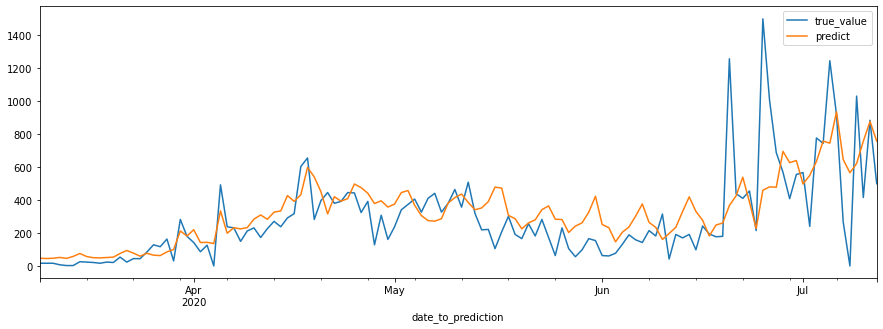

In [114]:
# Prédiction du train vs la réalité 
prediction_train.plot(figsize=(15,5))
'''
fig, ax = plt.subplots(figsize=(15,7))
plt.plot(test_res.index, test_res['real'],  label='Actual Values')
plt.plot(test_res.index, test_res['Prediction'], label='Predicted Values')
# If you don't like the break in the graph, change 90 to 89 in the above line
plt.gcf().autofmt_xdate()
plt.legend()
plt.show()
'''

In [115]:
print('Trains Metrics')
loss = tf.keras.losses.mean_squared_error(Y_train_real_bis, Y_train_pred_bis )
print('MSE',"{:.2f}".format(loss))
rmse = tf.sqrt(tf.losses.mean_squared_error(Y_train_real_bis, Y_train_pred_bis ))
print('RMSE',"{:.2f}".format(rmse))
loss2 = tf.keras.losses.MAE(Y_train_real_bis, Y_train_pred_bis )
print('MAE',"{:.2f}".format(loss2))
r2 =r2_score(Y_train_real_bis, Y_train_pred_bis )
print('R2',"{:.2f}".format(r2))
maxerror=max_error(Y_train_real_bis, Y_train_pred_bis )
print('maxError',"{:.2f}".format(maxerror))

Trains Metrics
MSE 43906.70
RMSE 209.54
MAE 135.36
R2 0.37
maxError 1159.15
